<a href="https://colab.research.google.com/github/qwqw16/E-commerce-Customer-Analytics/blob/main/E_commerce_Customer_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#关于数据集
这是一个跨国数据集，其中包含 2010 年 12 月 1 日至 2011 年 12 月 9 日之间发生的所有交易，这些交易来自一家总部位于英国且已注册的非实体店在线零售商。该公司主要销售独特的全场合礼品。

# 数据探索

在数据探索阶段，我们使用 SQL 查询 来分析客户的购买行为模式，特别关注 复购率（Repurchase Rate） 和 增长趋势（MoM、QoQ）。以下是主要的分析点：

##sql 整体复购率



*   首先计算了整体复购率，即至少有2笔订单的用户占比，其计算方式如下：






```
# sql
SELECT
    COUNT(DISTINCT CASE WHEN total_orders >= 2 THEN CustomerID END) * 100.0 / COUNT(DISTINCT CustomerID) AS repurchase_rate
FROM (
    SELECT CustomerID, COUNT(DISTINCT InvoiceNo) AS total_orders
    FROM sales_data
    GROUP BY CustomerID
) AS user_orders;
```





*   分析结果：
*   复购率约为 69.97%，说明大多数客户会进行多次购买。
*   但仍有 30% 的客户 仅购买过一次，需要针对这些用户提高复购策略。





##sql 按月份计算复购率
为了观察复购率的趋势，按月份计算了复购率：



```
# sql
SELECT
    DATE_FORMAT(sales_data.InvoiceDate, '%Y-%m') AS month,
    COUNT(DISTINCT CASE WHEN user_orders.total_orders >= 2 THEN sales_data.CustomerID END) * 100.0 /
    COUNT(DISTINCT sales_data.CustomerID) AS repurchase_rate
FROM (
    SELECT CustomerID, COUNT(DISTINCT InvoiceNo) AS total_orders
    FROM sales_data
    GROUP BY CustomerID
) AS user_orders
JOIN sales_data ON user_orders.CustomerID = sales_data.CustomerID
GROUP BY month
ORDER BY month;
```



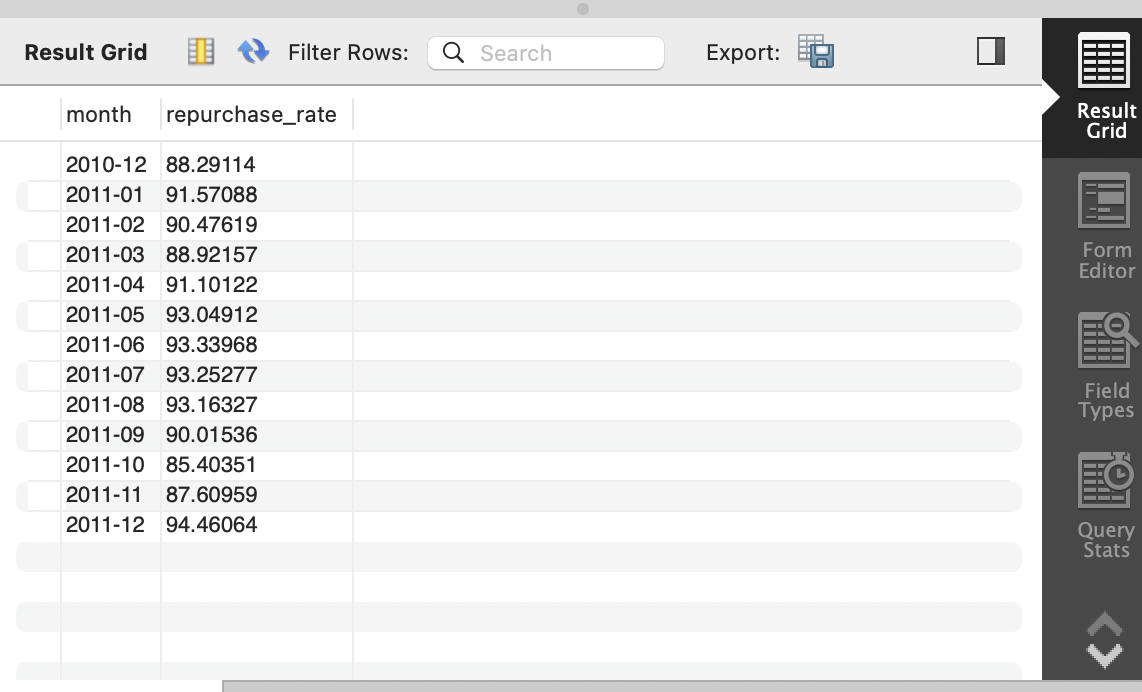


*   分析结果：
*   2011-05 到 2011-08 复购率高达 93%，说明该季度客户忠诚度较高，可能有促销或季节性影响。
*   2011-10 复购率下降至 85.40%，显示出用户的购买活跃度降低，可能需要营销干预。
*   2011-12 复购率上升到 94.46%，可能与节假日促销有关。




##sql 按月计算环比增长（MoM Growth）
为了更细致地观察复购率的变化，我们计算了 环比增长率（MoM Growth）：



```
# sql
WITH monthly_repurchase AS (
    SELECT
        DATE_FORMAT(InvoiceDate, '%Y-%m') AS month,
        COUNT(DISTINCT CASE WHEN total_orders >= 2 THEN sales_data.CustomerID END) * 100.0 /
        COUNT(DISTINCT sales_data.CustomerID) AS repurchase_rate
    FROM (
        SELECT CustomerID, COUNT(DISTINCT InvoiceNo) AS total_orders
        FROM sales_data
        GROUP BY CustomerID
    ) AS user_orders
    JOIN sales_data ON user_orders.CustomerID = sales_data.CustomerID
    GROUP BY month
)
SELECT
    month,
    repurchase_rate,
    LAG(repurchase_rate, 1) OVER (ORDER BY month) AS prev_month_rate,
    (repurchase_rate - LAG(repurchase_rate, 1) OVER (ORDER BY month)) / LAG(repurchase_rate, 1) OVER (ORDER BY month) * 100 AS MoM_growth
FROM monthly_repurchase
ORDER BY month;
```



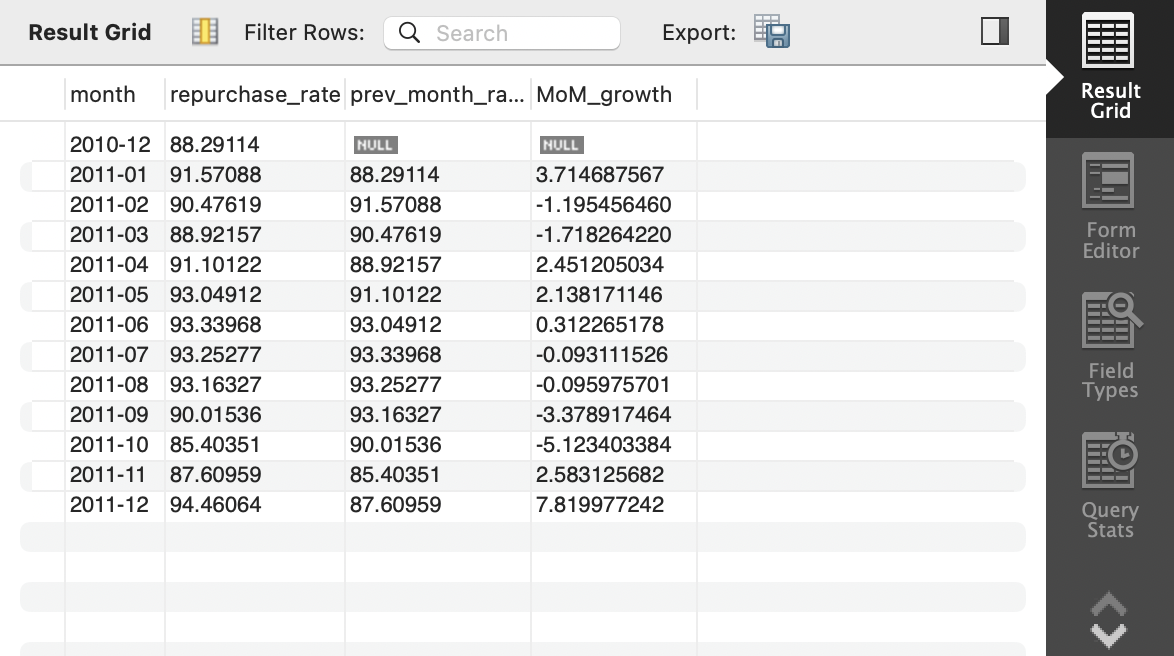


*   分析结果：
*   2011-01 复购率增长 3.71%，说明年初市场活动可能有效。
*   2011-09 ~ 2011-10 出现了 -5.12% 的下降，可能是因为市场需求疲软。
*   2011-12 复购率环比增长 7.81%，进一步确认了年底促销的正面作用。



##sql 按季度计算环比增长（QoQ Growth）




```
# sql
WITH quarterly_repurchase AS (
    SELECT
        CONCAT(YEAR(InvoiceDate), '-Q', QUARTER(InvoiceDate)) AS quarter,
        COUNT(DISTINCT CASE WHEN total_orders >= 2 THEN sales_data.CustomerID END) * 100.0 /
        COUNT(DISTINCT sales_data.CustomerID) AS repurchase_rate
    FROM (
        SELECT CustomerID, COUNT(DISTINCT InvoiceNo) AS total_orders
        FROM sales_data
        GROUP BY CustomerID
    ) AS user_orders
    JOIN sales_data ON user_orders.CustomerID = sales_data.CustomerID
    GROUP BY quarter
)
SELECT
    quarter,
    repurchase_rate,
    LAG(repurchase_rate, 1) OVER (ORDER BY quarter) AS prev_quarter_rate,
    (repurchase_rate - LAG(repurchase_rate, 1) OVER (ORDER BY quarter)) / LAG(repurchase_rate, 1) OVER (ORDER BY quarter) * 100 AS QoQ_growth
FROM quarterly_repurchase
ORDER BY quarter;
```



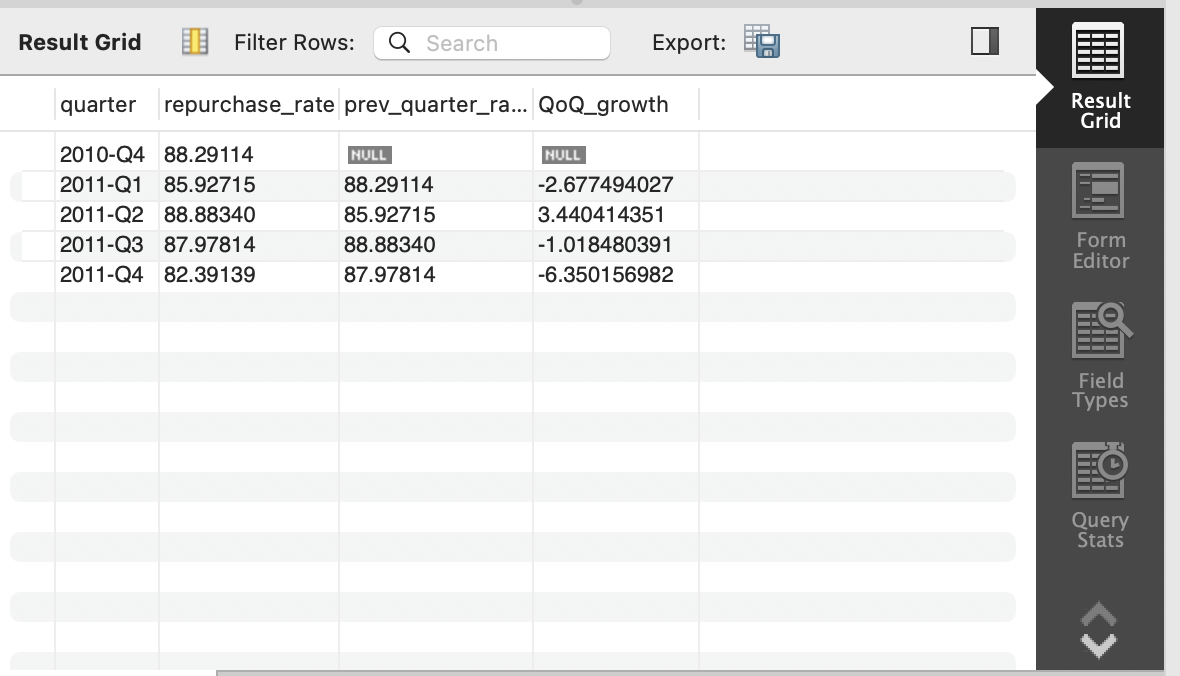


*   分析结果：
*   2011-Q1 复购率下降 -2.68%，可能是圣诞节后市场回落。
*   2011-Q2 复购率增长 3.44%，表明市场进入稳定增长期。
*   2011-Q4 复购率下降 -6.35%，可能是由于年底订单积压，部分客户推迟购买。



##总结
主要发现：
1. 复购率稳定在 70%-94% 之间，大多数客户会进行多次购买。
2. 2011 年中期（5-8 月）复购率最高，说明该时间段市场活动有效。
3. 10 月份复购率下降至 85.40%，显示出用户活跃度下滑，需要营销干预。
4. 年底复购率增长（94.46%），假日促销可能是主要驱动力。
5. 季度环比下降（Q4） 需要关注，特别是在年末订单积压问题。

##Tableau 每月复购率分析
在数据探索阶段，我们利用 Tableau 进行了初步的数据分析，以更直观地理解客户行为、复购模式以及用户价值分层。



*   目标：计算并可视化每月的复购率，以评估客户忠诚度。

*   方法：

1. 计算每月下单次数 ≥2 的复购用户数：
```
# IF { FIXED [Customer ID], DATE_TRUNC('month', [Invoice Date]): COUNTD([Invoice No]) } >= 2
THEN 1 ELSE 0 END
```
2. 计算该月的总用户数：
```
# { FIXED DATE_TRUNC('month', [Invoice Date]): COUNTD([Customer ID]) }
```
3. 计算最终的复购率：
```
# SUM([复购用户数]) / SUM([总用户数])
```


*   可视化：
*   在 Tableau 中绘制 时间序列折线图，纵轴为复购率，横轴为月份，观察复购率的变化趋势。




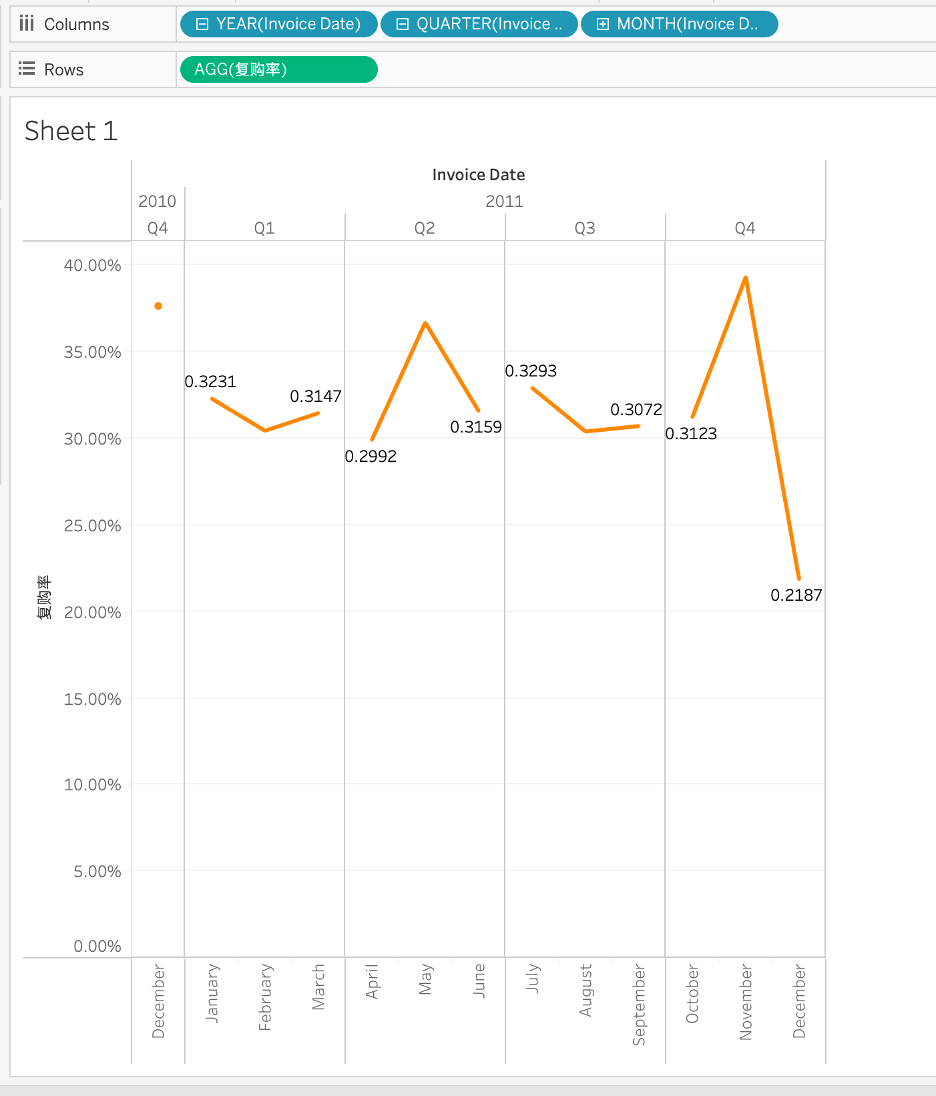

##Tableau RFM 分析(初步识别高价值客户)



*   目标：通过 RFM（Recency、Frequency、Monetary） 识别高价值客户，并进行客户分层。

*   R 指标（最近一次购买时间）：计算每个用户距当前时间的最后一次购买时间。数值越小，代表该用户近期仍活跃。

*   F 指标（购买频率）：计算每个用户的订单总数。数值越高，代表用户忠诚度较高。

*   M 指标（消费金额）：计算用户的总消费金额。数值越高，代表用户贡献较高的营收。
*   RFM 评分：将 R、F、M 指标按区间划分为 1-5 级，R 越低、F 和 M 越高，则用户评分越高。最终计算 RFM 总评分 = R + F + M。





计算 RFM 指标：
1. R（最近一次购买时间）：
```
# DATEDIFF('day', { FIXED [Customer ID]: MAX([Invoice Date]) }, #2011-12-31#)
```
2. F（购买频率）：
```
# { FIXED [Customer ID]: COUNTD([Invoice No]) }
```
3. M（消费金额）：
```
# { FIXED [Customer ID]: SUM([Total Amount]) }
```





计算 RFM 评分：
1. R 评分：
```
# IF [R_最近购买天数] <= 30 THEN 5
ELSEIF [R_最近购买天数] <= 90 THEN 4
ELSEIF [R_最近购买天数] <= 180 THEN 3
ELSEIF [R_最近购买天数] <= 365 THEN 2
ELSE 1 END
```
2. F 评分：
```
# IF [F_购买频率] >= 20 THEN 5
ELSEIF [F_购买频率] >= 10 THEN 4
ELSEIF [F_购买频率] >= 5 THEN 3
ELSEIF [F_购买频率] >= 2 THEN 2
ELSE 1 END
```
3. M 评分：
```
# IF [M_消费金额] >= 5000 THEN 5
ELSEIF [M_消费金额] >= 2000 THEN 4
ELSEIF [M_消费金额] >= 1000 THEN 3
ELSEIF [M_消费金额] >= 500 THEN 2
ELSE 1 END
```
4. 计算 RFM 总分：
```
# [R_评分] + [F_评分] + [M_评分]
```






*   客户价值分层：
```
# IF [RFM_总评分] >= 12 THEN "高价值客户"
ELSEIF [RFM_总评分] >= 8 THEN "中等价值客户"
ELSE "低价值客户" END
```
*   高价值客户（RFM ≥ 12）：近期购买、购买频繁、消费金额大，需重点维护。
*   中等价值客户（8 ≤ RFM < 12）：有一定忠诚度，适合促销策略。
*   低价值客户（RFM < 8）：长时间未购买，需挖掘潜在需求。



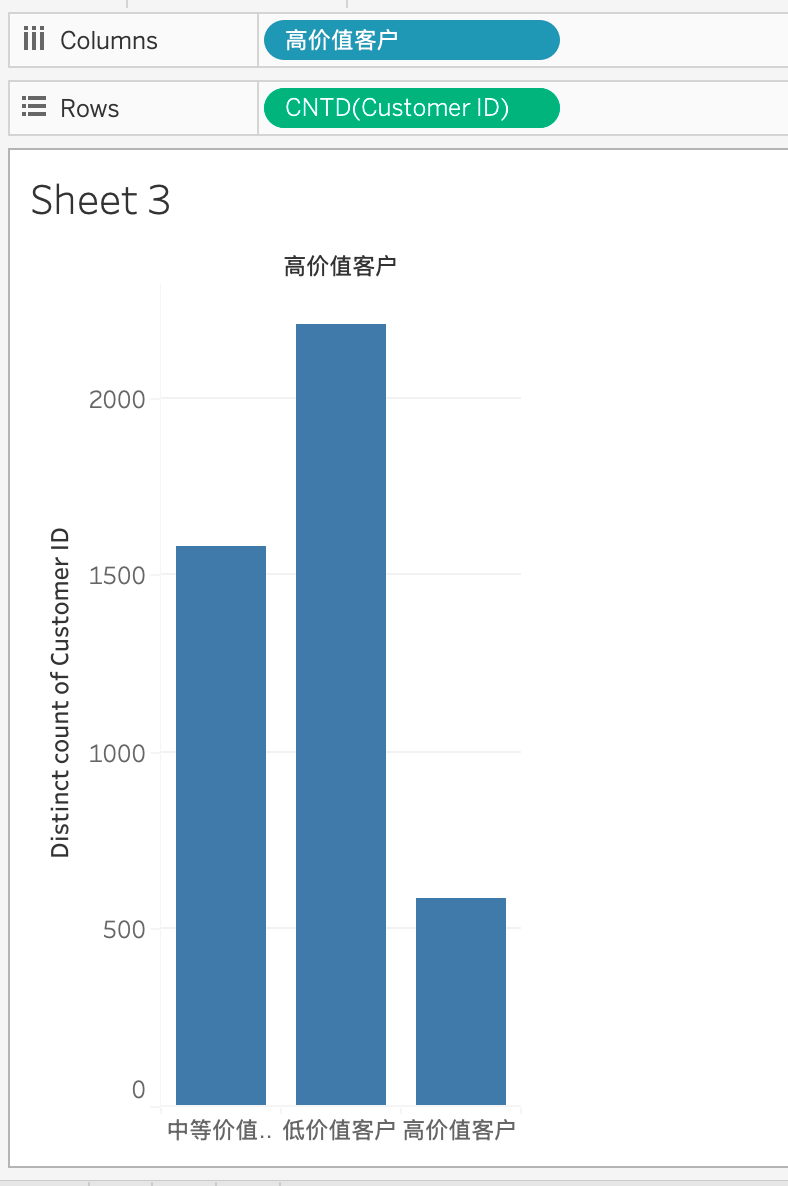

##Tableau 动态 RFM 用户分层


*   改进用户价值分层计算，使其动态调整

*   目标：让 RFM 评分的高低标准可以动态调整，而不是固定阈值。

*   方法：
1. 创建两个动态参数：
```
RFM_Threshold_High（默认值：12，范围 3-15）
RFM_Threshold_Low（默认值：8，范围 3-15）
```
2. 改进分层计算字段：
```
IF [RFM_总评分] >= [RFM_Threshold_High] THEN "高价值客户"
ELSEIF [RFM_总评分] >= [RFM_Threshold_Low] THEN "中等价值客户"
ELSE "低价值客户"
END
```
3. 可视化：
在 Tableau Show Parameter，可以动态调整 RFM_Threshold_High 和 RFM_Threshold_Low，实时查看用户分层变化。




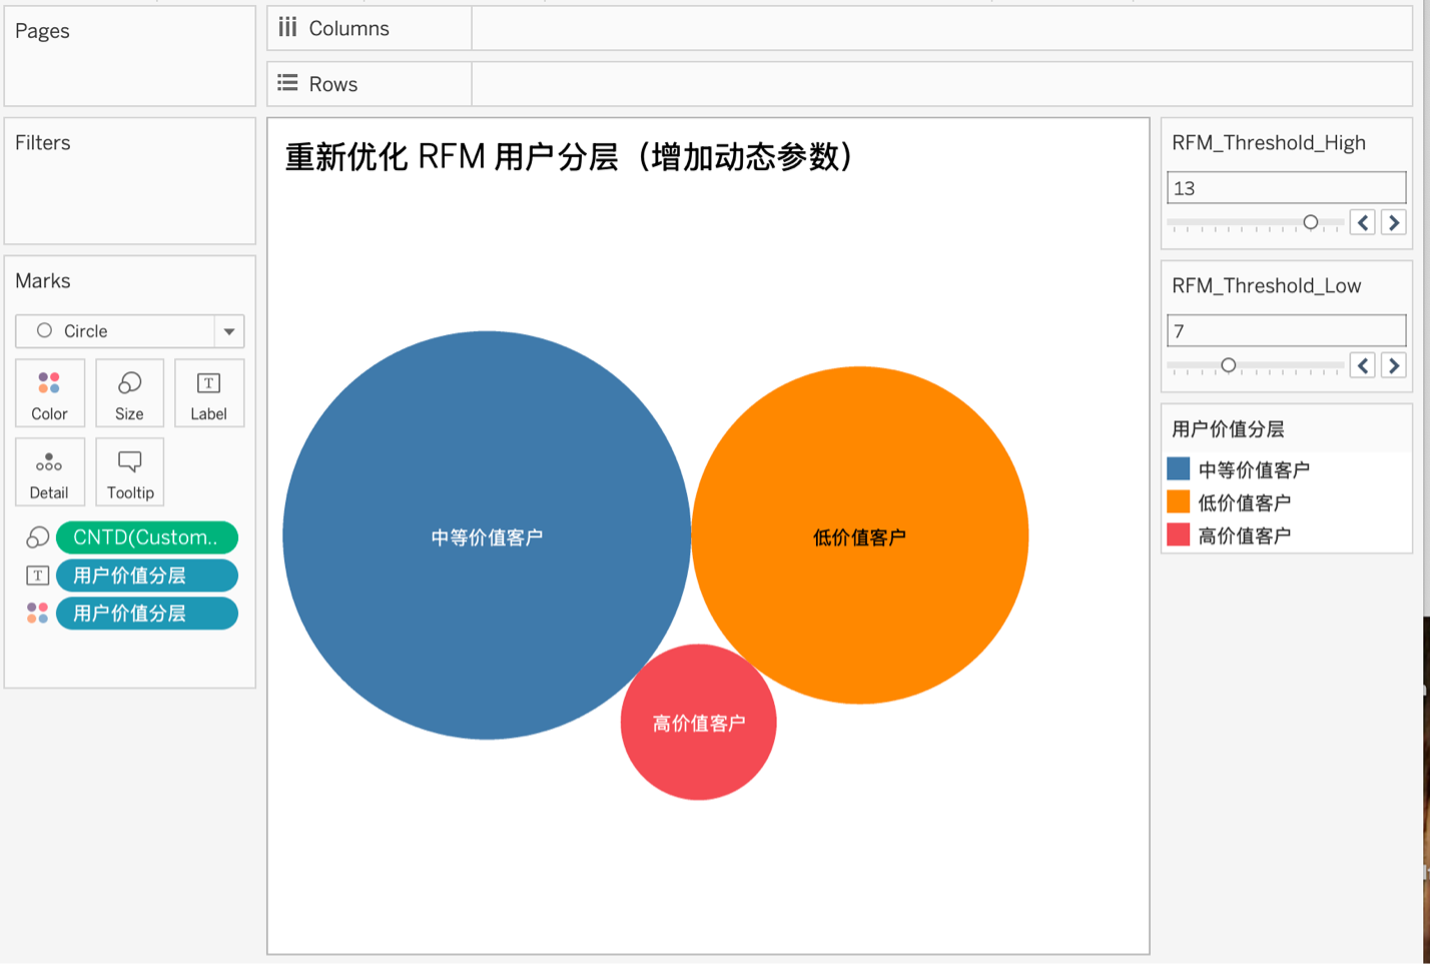

##Tableau 地理分布地图


*   目标：可视化不同国家/地区的客户分布，识别不同市场的客户行为。
*   方法：
1. 拖拽 Country 字段 到 Marks 里的 Detail。
2. 拖拽 COUNTD([Customer ID]) 到 Size，让气泡大小反映客户数量。
3. 拖拽高价值客户分层到 Color，区分高、中、低价值客户。
*   某些国家（如英国、德国）贡献较大营收，高价值客户较多。
*   低价值客户集中在某些特定市场，可能是受市场因素或物流影响。



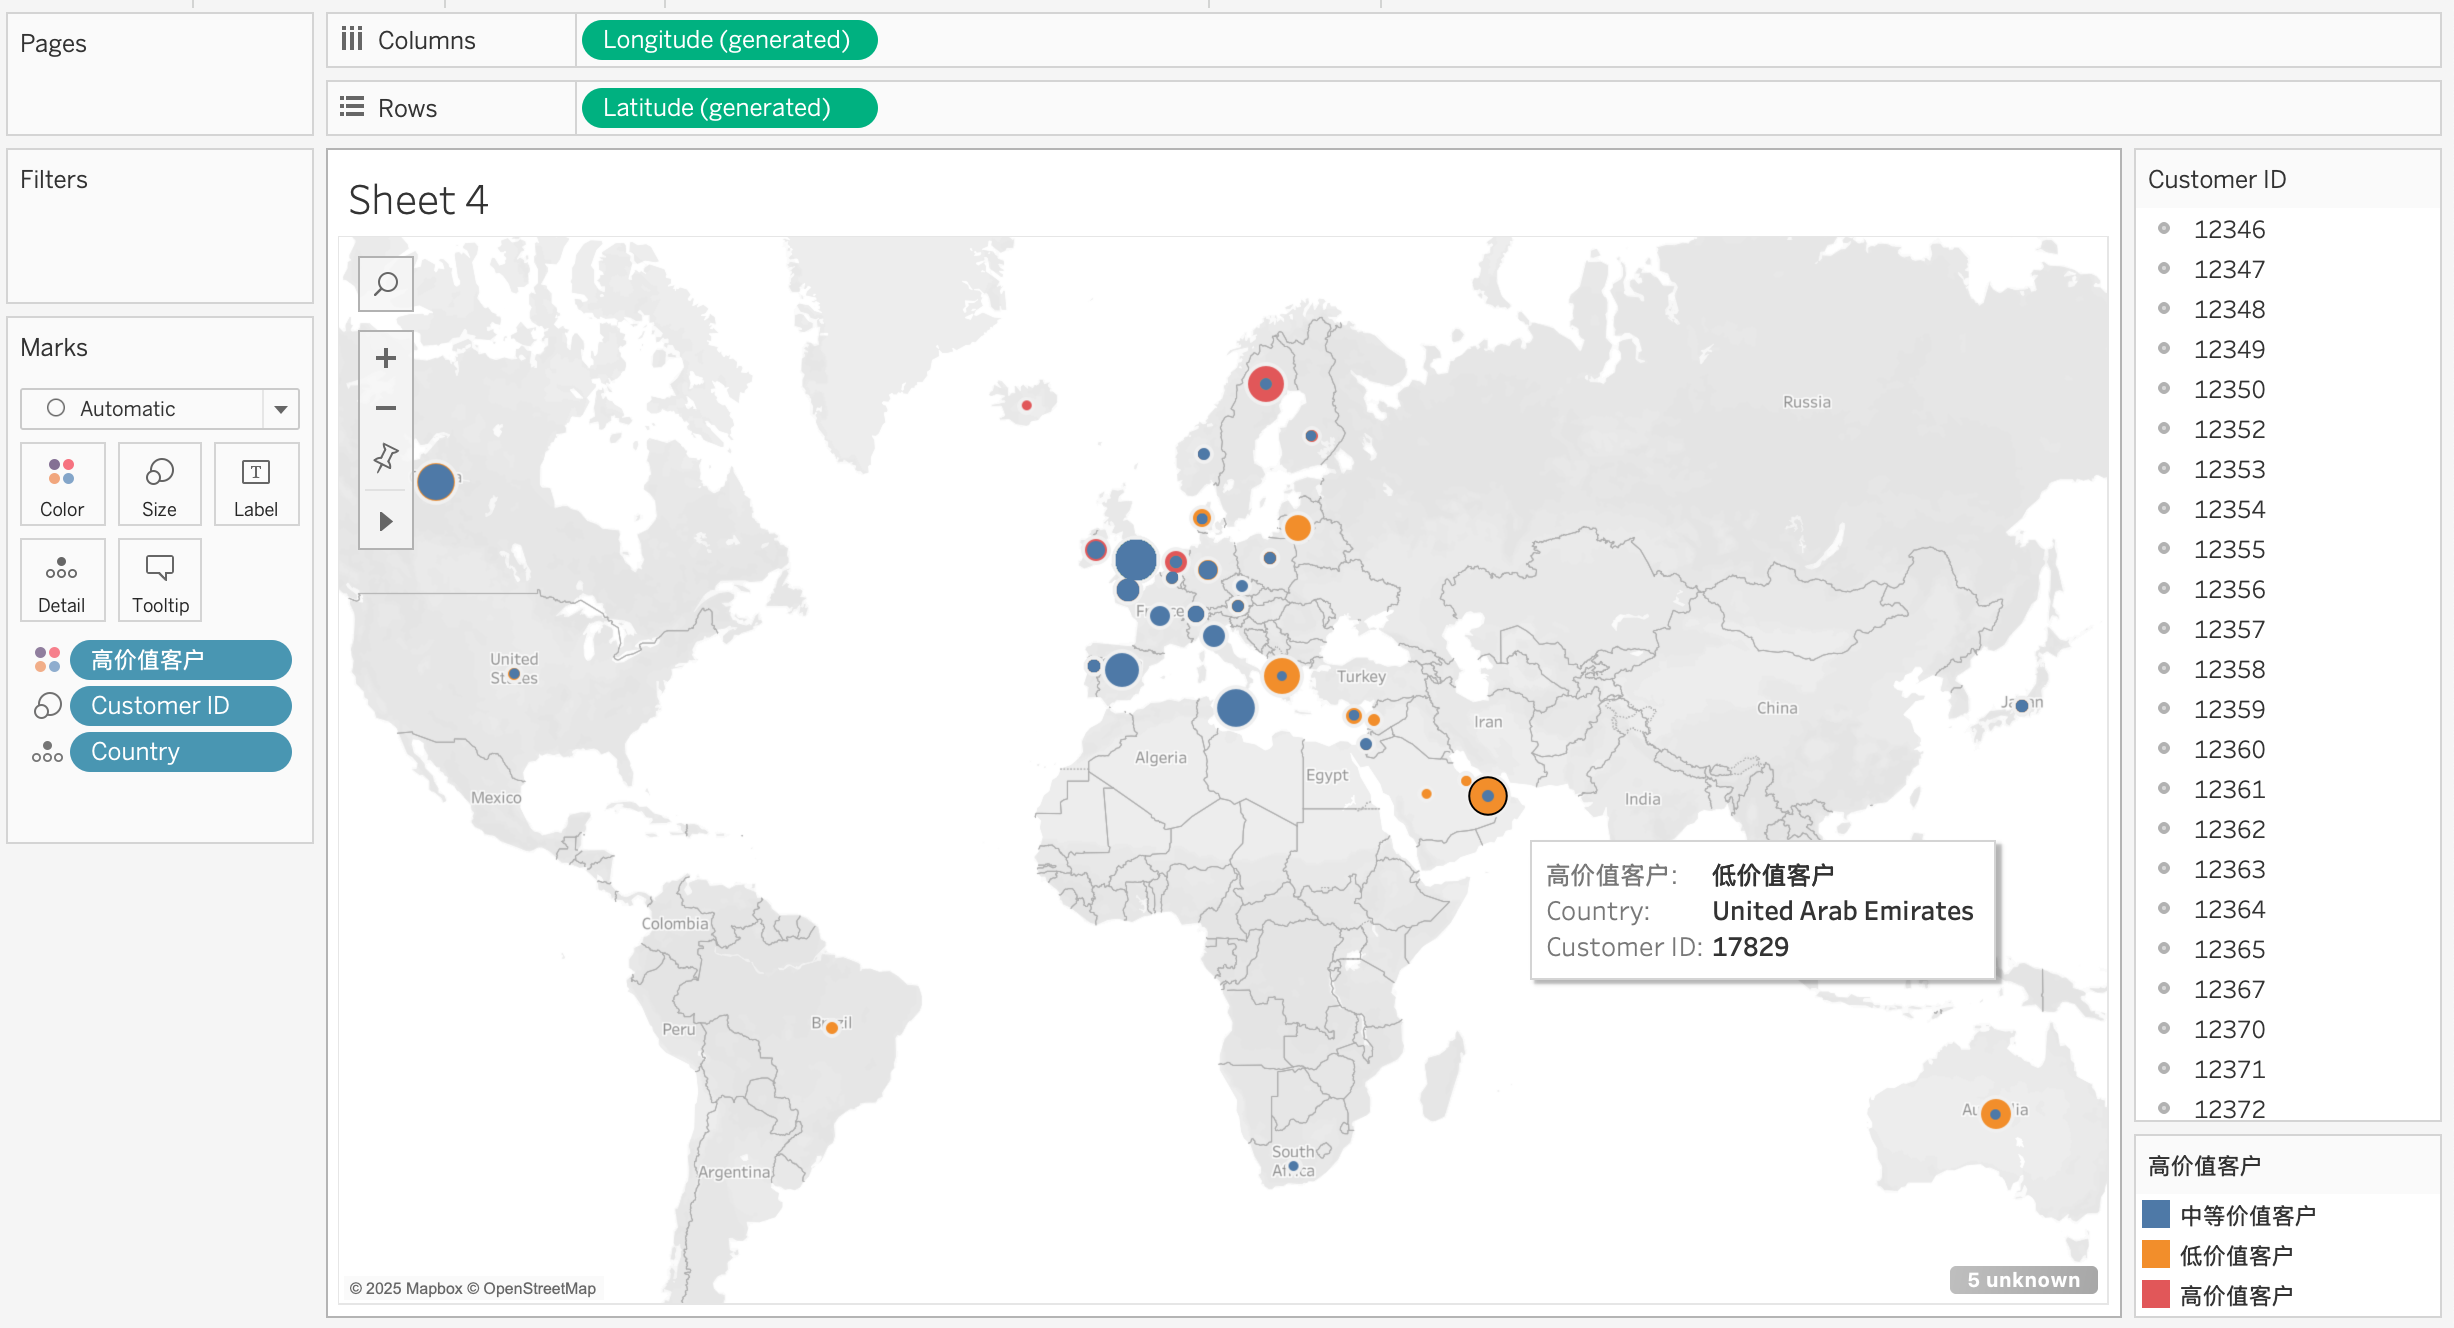

##总结
*   复购率分析 显示了客户在不同月份的忠诚度趋势。
*   RFM 分析 识别了高价值客户，并对客户进行了分层。
*   动态 RFM 分层 使得用户分层更灵活，可以动态调整阈值。
*   地理分布分析 展示了不同地区的客户分布及价值情况，为市场策略提供支持。



# 数据清洗













##发现的问题

1.   数据缺失
*   CustomerID：共 135,080 条记录缺失，占比约 25%。这些数据对后续产品分类和客户分类分析至关重要，因此删除缺失的客户 ID 记录。
*   Description（商品描述）：有 1,454 条缺失值，但不会影响数值分析。


2.   数据类型不一致
*   InvoiceDate 存储为 字符串格式，需要转换为 datetime 类型以支持时间序列分析。


3.   存在异常数据
*   Quantity（商品数量）：发现 负值记录，可能是订单退货的标记。
*   UnitPrice（单价）：发现部分 单价为 0 的记录，可能是促销活动或异常数据。



##清洗策略



1.   处理缺失值
*   删除 CustomerID 为空的行，确保后续客户分析的准确性。

2.   处理数据类型
*   将 InvoiceDate 转换为日期时间格式，以便时间窗口分析。



In [ ]:
import pandas as pd

# 读取数据
df = pd.read_csv("/content/data.csv",
                 encoding='latin-1',  # 核心：解决编码问题
                 )

# 查看数据
print("数据加载成功！前5行示例：")
df.head()

数据加载成功！前5行示例：


InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom

In [ ]:
# 1️⃣ 加载 Pandas
import pandas as pd

# 2️⃣ 查看数据基本信息
print("数据概览：")
df.info()
df.isnull().sum()#统计各列缺失值

数据概览：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

##清洗后的成果

1.   经过数据清理后，我们得到一个更加可靠的数据集：

*   删除 CustomerID 为空的数据，确保每条记录都属于一个具体的客户。
*   将 InvoiceDate 转换为 datetime 类型，支持时间序列分析。
*   新增 TotalAmount（订单总金额），方便后续的产品分类和客户分类。
*   最终的数据存储为 cleaned_data.csv，用于后续 SQL 分析、产品分类、客户分类、Tableu可视化等任务。



In [ ]:
from google.colab import drive
import pandas as pd



# 复制数据，避免修改原始 DataFrame
cleaned_df = df.copy()

# 删除 `CustomerID` 为空的行（无法用于分析）
cleaned_df = cleaned_df.dropna(subset=['CustomerID'])

# 转换 `InvoiceDate` 为 `datetime` 格式，保证后续 SQL 分析、可视化和机器学习任务顺利进行
cleaned_df["InvoiceDate"] = pd.to_datetime(cleaned_df["InvoiceDate"])

# 计算订单总金额（TotalAmount）
cleaned_df["TotalAmount"] = cleaned_df["Quantity"] * cleaned_df["UnitPrice"]

# **保存聚类结果**
cleaned_df.to_csv("/content/cleaned_data.csv", index=False)
print("✅ 数据清洗成功，结果已保存到 cleaned_data.csv")

# 显示前5行数据
print("必要清洗操作完成，前5行数据如下：")
print(cleaned_df.head())
cleaned_df.info()

✅ 数据清洗成功，结果已保存到 cleaned_data.csv
必要清洗操作完成，前5行数据如下：
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalAmount  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom        15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom        20.34  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom        22.00  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom        20.34  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom        20.34  
<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries,

# 产品分类



##目标

*   识别不同类型的产品类别
*   了解各类别产品的特点
*   通过聚类方法对产品进行分类，以便更好地进行市场分析和推荐


##数据预处理
*   去除空值：删除无 Description 的记录
*   文本标准化：转换为小写，移除特殊字符，进行分词、去除停用词，词干化（Stemming）



In [ ]:
import nltk
import os

# Download Punkt Tokenizer Models if needed
nltk.download('punkt', download_dir='/usr/local/nltk_data')
nltk.download('punkt_tab', download_dir='/usr/local/nltk_data')
nltk.download('stopwords', download_dir='/usr/local/nltk_data')
nltk.download('wordnet', download_dir='/usr/local/nltk_data')

# Add the NLTK data path to the search path.
nltk.data.path.append("/usr/local/nltk_data")

import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re

# 读取数据
df = pd.read_csv("/content/cleaned_data.csv")


# 过滤非空 Description
df = df.dropna(subset=["Description"])

# 预处理函数
def preprocess_text(text):
    text = text.lower()  # 转小写
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # 去除特殊字符
    tokens = word_tokenize(text)  # 分词
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # 去除停用词
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]  # 词干化
    return " ".join(tokens)

# 应用预处理
df["ProcessedDescription"] = df["Description"].apply(preprocess_text)

# 显示前几行
df[["Description", "ProcessedDescription"]].head()

[nltk_data] Downloading package punkt to /usr/local/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /usr/local/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /usr/local/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /usr/local/nltk_data...


Description             ProcessedDescription
0   WHITE HANGING HEART T-LIGHT HOLDER   white hang heart tlight holder
1                  WHITE METAL LANTERN              white metal lantern
2       CREAM CUPID HEARTS COAT HANGER    cream cupid heart coat hanger
3  KNITTED UNION FLAG HOT WATER BOTTLE  knit union flag hot water bottl
4       RED WOOLLY HOTTIE WHITE HEART.     red woolli hotti white heart

##采用的方法

*   TF-IDF 向量化：为了进行文本分析，我们使用 TF-IDF（词频-逆文档频率） 方法，将产品描述转换为向量。选择了 1,000 个高频词 作为特征输入。

*   K-Means 聚类：为了对产品进行分类，我们采用 MiniBatchKMeans 进行聚类，并使用 肘部法则（Elbow Method） 选择最佳簇数。



*   K 值范围： 2 ~ 10

*   评估指标： SSE（误差平方和）和 Silhouette Score（轮廓系数）
最终选择最佳 K 值：6




正在计算 K=2 ...
正在计算 K=3 ...
正在计算 K=4 ...
正在计算 K=5 ...
正在计算 K=6 ...
正在计算 K=7 ...
正在计算 K=8 ...
正在计算 K=9 ...


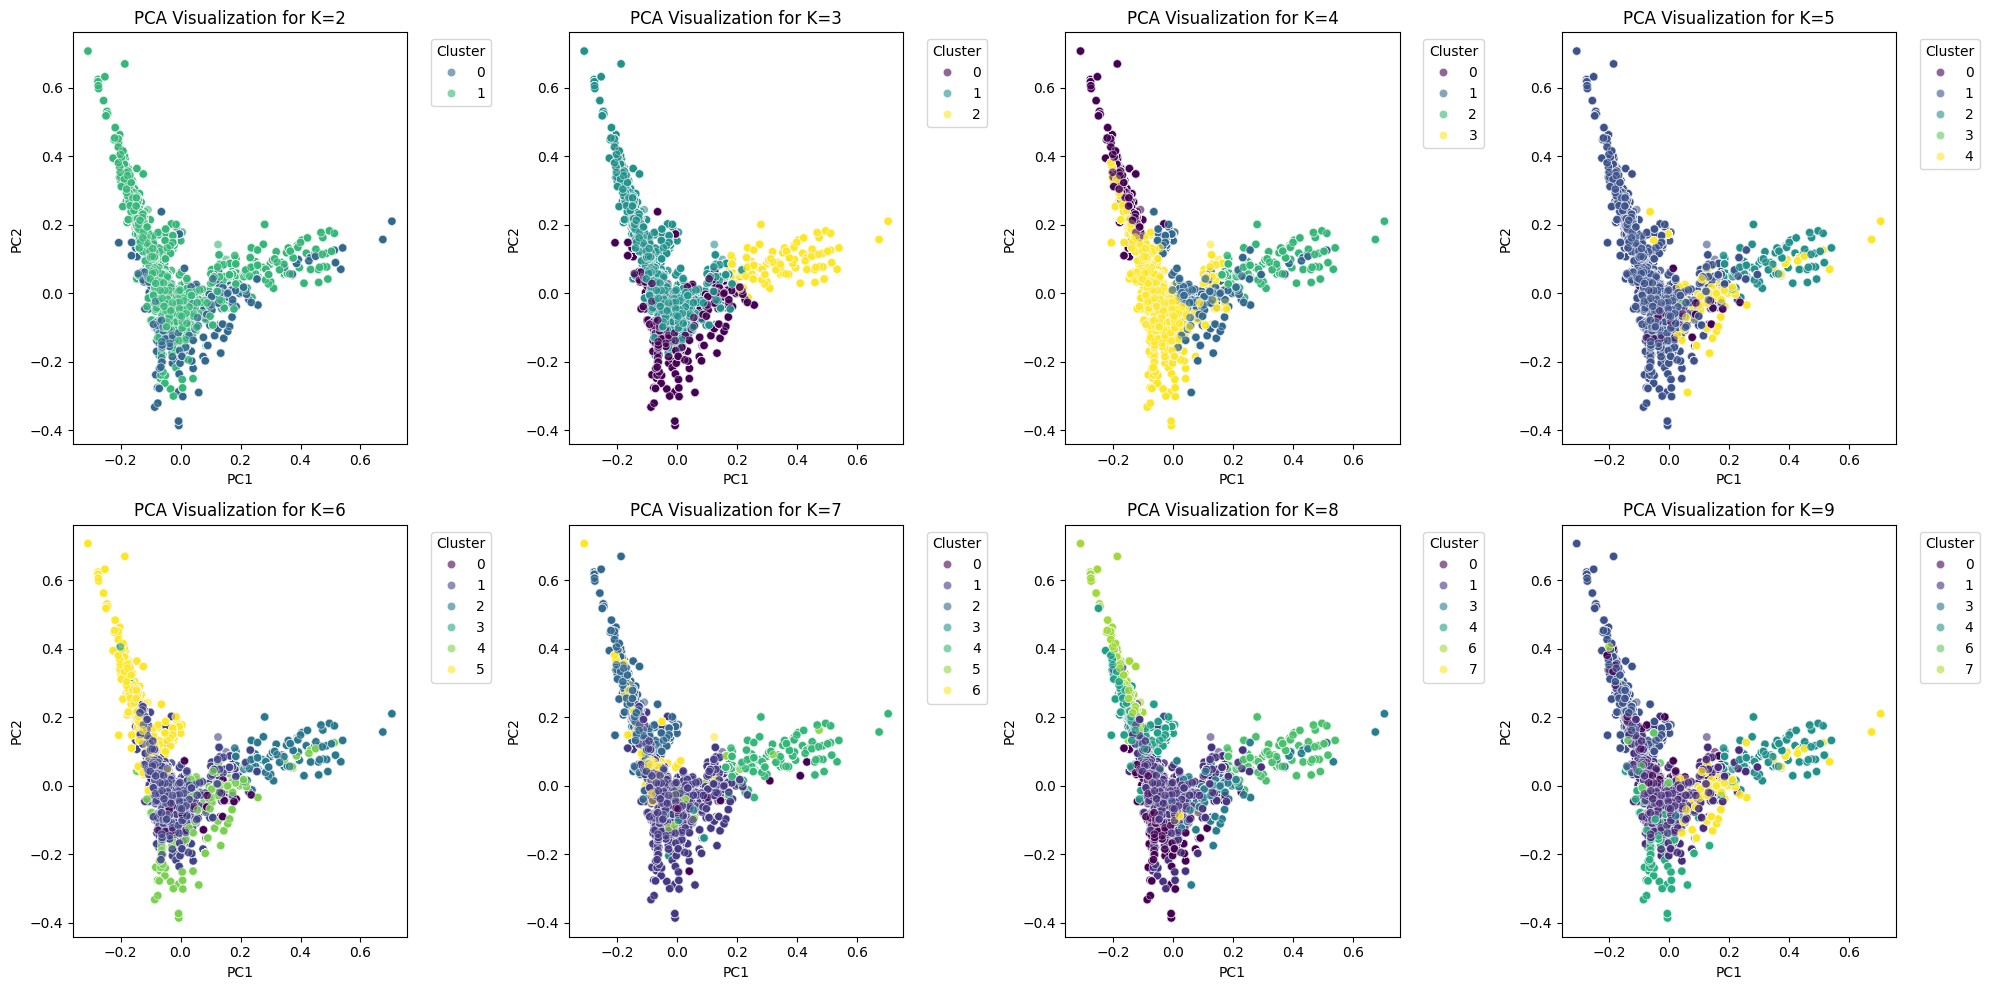

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
# 计算 TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(df["ProcessedDescription"])

# 设置 K 值范围
K_range = range(2, 10)

# 存储 SSE 和 Silhouette Score
sse = []
silhouette_scores = []

# 逐个 K 值进行聚类并绘制 PCA 降维图
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 创建 2 行 4 列的子图
axes = axes.flatten()  # 将子图对象展平，方便索引

for i, k in enumerate(K_range):
    print(f"正在计算 K={k} ...")

    # MiniBatchKMeans 进行聚类
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, n_init=10, batch_size=100)
    labels = kmeans.fit_predict(X_tfidf)

    # 计算 SSE 和 Silhouette Score
    sse.append(kmeans.inertia_)
    sample_size = min(5000, X_tfidf.shape[0])
    silhouette_scores.append(silhouette_score(X_tfidf[:sample_size], labels[:sample_size]))

    # PCA 降维
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_tfidf.toarray())

    # 创建 DataFrame 进行可视化
    df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
    df_pca["Cluster"] = labels

    # 绘制 PCA 聚类散点图
    sns.scatterplot(ax=axes[i], x="PC1", y="PC2", hue="Cluster", palette="viridis", data=df_pca, alpha=0.6)
    axes[i].set_title(f"PCA Visualization for K={k}")
    axes[i].legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

# 调整子图间距
plt.tight_layout()
plt.show()


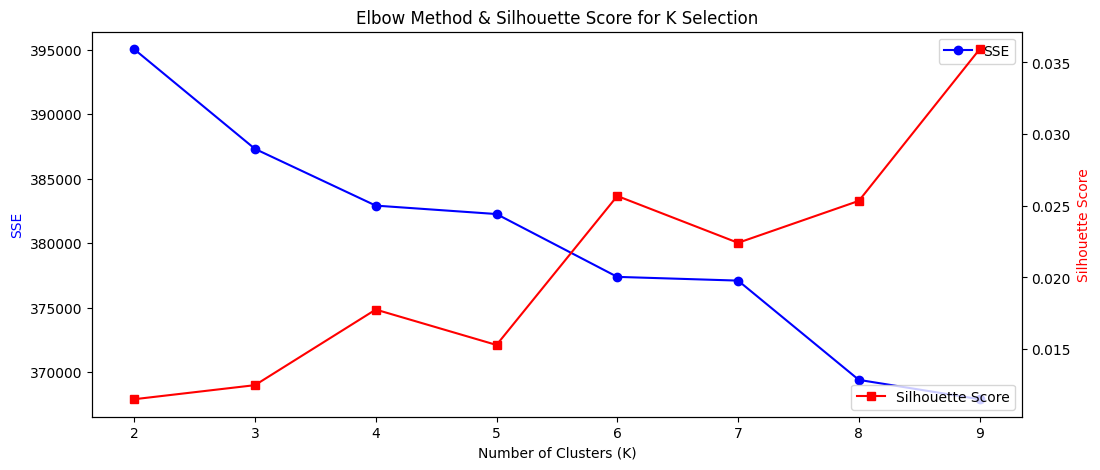

In [ ]:
# **绘制 Elbow Method & Silhouette Score**
fig, ax1 = plt.subplots(figsize=(12, 5))
ax2 = ax1.twinx()

ax1.plot(K_range, sse, marker='o', linestyle='-', color='b', label='SSE')
ax2.plot(K_range, silhouette_scores, marker='s', linestyle='-', color='r', label='Silhouette Score')

ax1.set_xlabel("Number of Clusters (K)")
ax1.set_ylabel("SSE", color='b')
ax2.set_ylabel("Silhouette Score", color='r')
ax1.set_title("Elbow Method & Silhouette Score for K Selection")

ax1.legend(loc="upper right")
ax2.legend(loc="lower right")

plt.show()

In [ ]:
# **选择最佳 K 进行 MiniBatchKMeans 聚类**
optimal_k = 6
print(f"✅ 选择的最佳 K 值: {optimal_k}")

kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, n_init=10, batch_size=100)
df["ProductCluster"] = kmeans.fit_predict(X_tfidf)

# **显示商品分类**
print(df[["Description", "ProductCluster"]].head(10))

# **保存聚类结果**
df.to_csv("/content/clustered_products.csv", index=False)
print("✅ 商品聚类完成，结果已保存到 clustered_products.csv")

✅ 选择的最佳 K 值: 6
                           Description  ProductCluster
0   WHITE HANGING HEART T-LIGHT HOLDER               5
1                  WHITE METAL LANTERN               1
2       CREAM CUPID HEARTS COAT HANGER               5
3  KNITTED UNION FLAG HOT WATER BOTTLE               1
4       RED WOOLLY HOTTIE WHITE HEART.               5
5         SET 7 BABUSHKA NESTING BOXES               0
6    GLASS STAR FROSTED T-LIGHT HOLDER               5
7               HAND WARMER UNION JACK               1
8            HAND WARMER RED POLKA DOT               1
9        ASSORTED COLOUR BIRD ORNAMENT               1
✅ 商品聚类完成，结果已保存到 clustered_products.csv



##结果分析

*   聚类结果

*   词云分析

*   为进一步理解各个类别的主要产品，使用 词云（WordCloud） 可视化产品类别的关键词：

*   Cluster 0：包含 "babushka", "boxes"
*   Cluster 1：包含 "lantern", "hand warmer"
*   Cluster 2：包含 "bird ornament"
*   Cluster 3：包含 "glass", "star", "frosted"
*   Cluster 4：包含 "woolly", "hottie"
*   Cluster 5：包含 "heart", "t-light holder"







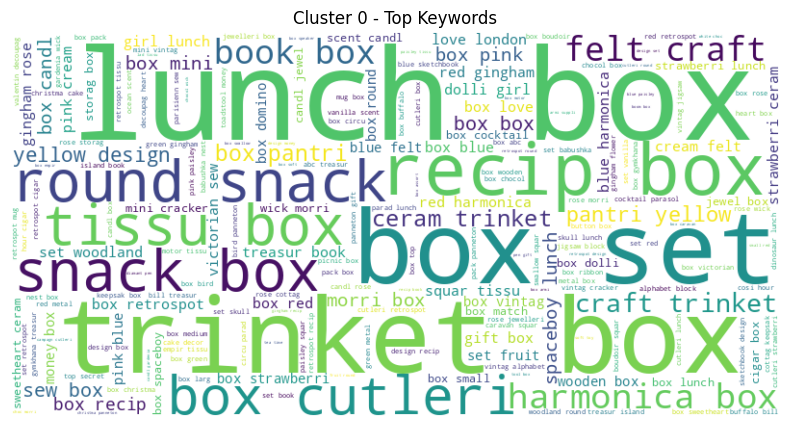

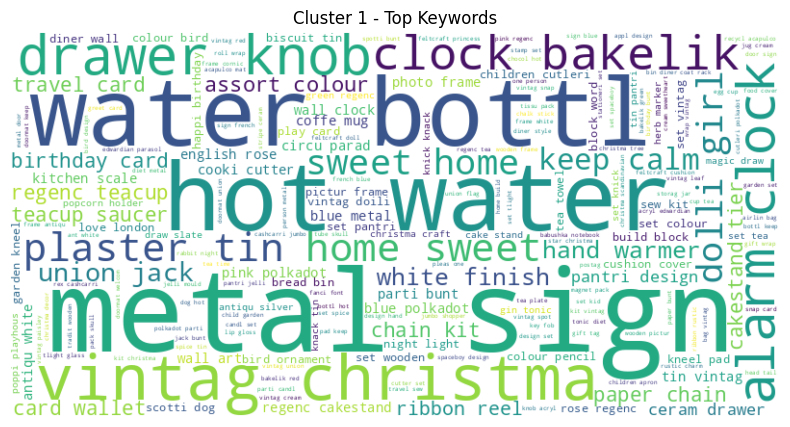

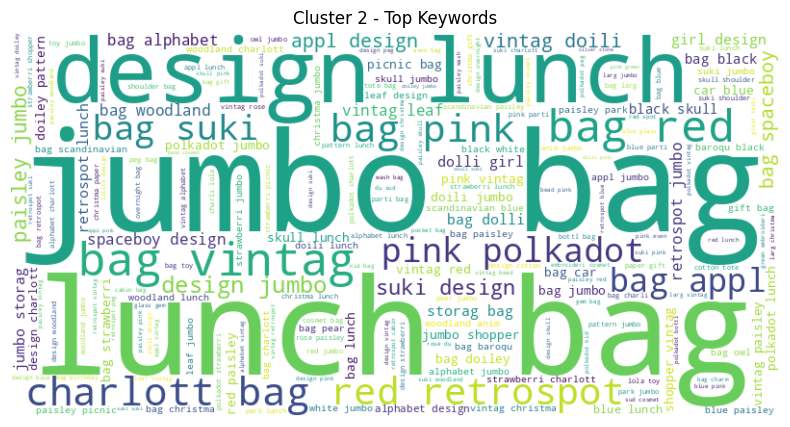

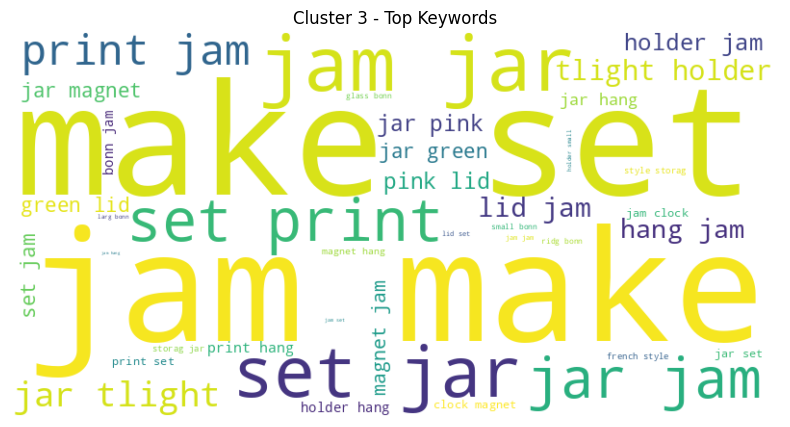

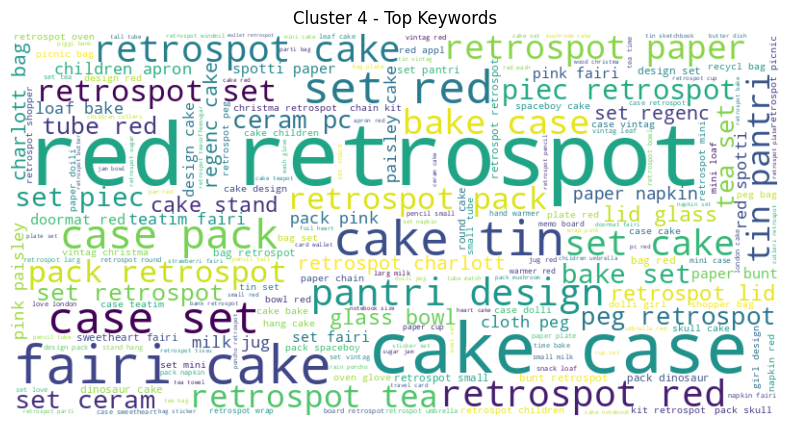

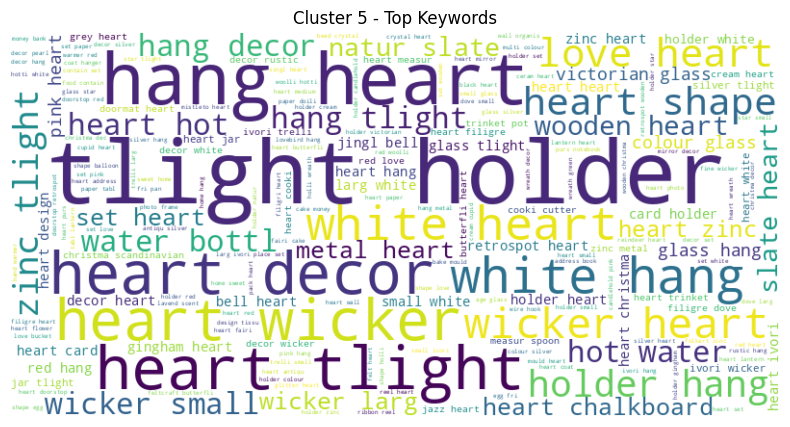

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# **绘制词云**
def plot_wordcloud(cluster_num):
    text = " ".join(df[df["ProductCluster"] == cluster_num]["ProcessedDescription"])
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cluster {cluster_num} - Top Keywords")
    plt.show()

# **为每个类别生成词云**
for cluster in sorted(df["ProductCluster"].unique()):
    plot_wordcloud(cluster)


##结论

*   Cluster 0 主要为 嵌套式礼品盒
*   Cluster 1 主要为 灯具、加热产品
*   Cluster 2 主要为 装饰类产品
*   Cluster 3 主要为 玻璃制品
*   Cluster 4 主要为 羊毛制品
*   Cluster 5 主要为 心形装饰品


# 客户分类

*   采用 MiniBatchKMeans 对客户进行了聚类分析，最终选择了 K=7 作为最佳簇数，划分出 7种不同类型的客户群体。


##选取特征  
计算客户购买行为特征，包括订单数量、总消费、购买频率、独特产品种类、最近购买时间等。





In [ ]:
import pandas as pd

# 读取数据
df = pd.read_csv("/content/clustered_products.csv")

# 确保 InvoiceDate 是 datetime 格式
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# 计算每个客户的购买行为特征
customer_features = df.groupby("CustomerID").agg(
    TotalOrders=("InvoiceNo", "nunique"),  # 订单数
    MinOrderValue=("TotalAmount", "min"),  # 最小订单金额
    MaxOrderValue=("TotalAmount", "max"),  # 最大订单金额
    AvgOrderValue=("TotalAmount", "mean"), # 平均订单金额
    TotalSpent=("TotalAmount", "sum"),     # 总消费金额
    UniqueProductsBought=("StockCode", "nunique"),  # 购买的不同产品种类
    FirstPurchaseDate=("InvoiceDate", "min"),  # 第一次购买时间
    LastPurchaseDate=("InvoiceDate", "max")   # 最近一次购买时间
).reset_index()

# 计算距离上次购买的天数
customer_features["DaysSinceLastPurchase"] = (df["InvoiceDate"].max() - customer_features["LastPurchaseDate"]).dt.days

# 计算购买频率
customer_features["PurchaseFrequency"] = customer_features["TotalOrders"] / (customer_features["DaysSinceLastPurchase"] + 1)

# **计算客户在不同商品类别的消费占比**
# 确保 ProductCluster 存在
if "ProductCluster" not in df.columns:
    raise ValueError("数据集中没有 'ProductCluster'，请先进行产品聚类！")

# 计算每个客户在不同类别的消费占比
category_spend = df.pivot_table(index="CustomerID", columns="ProductCluster", values="TotalAmount", aggfunc="sum", fill_value=0)

# 归一化每个客户在不同类别的消费占比
category_spend = category_spend.div(category_spend.sum(axis=1), axis=0).fillna(0)

# 重命名列
category_spend.columns = [f"Category_{col}" for col in category_spend.columns]

# 合并到 `customer_features`
customer_features = customer_features.merge(category_spend, on="CustomerID", how="left")

# 删除时间字段，确保所有特征数值化
customer_features.drop(columns=["FirstPurchaseDate", "LastPurchaseDate"], inplace=True)

# 显示前几行数据
print(customer_features.head())

# **保存特征数据**
customer_features.to_csv("/content/customer_features.csv", index=False)
print("✅ 客户特征数据已保存！")


   CustomerID  TotalOrders  MinOrderValue  MaxOrderValue  AvgOrderValue  \
0     12346.0            2      -77183.60        77183.6       0.000000   
1     12347.0            7           5.04          249.6      23.681319   
2     12348.0            4          13.20          240.0      57.975484   
3     12349.0            1           6.64          300.0      24.076027   
4     12350.0            1           8.50           40.0      19.670588   

   TotalSpent  UniqueProductsBought  DaysSinceLastPurchase  PurchaseFrequency  \
0        0.00                     1                    325           0.006135   
1     4310.00                   103                      1           3.500000   
2     1797.24                    22                     74           0.053333   
3     1757.55                    73                     18           0.052632   
4      334.40                    17                    309           0.003226   

   Category_0  Category_1  Category_2  Category_3  Category_4 

##采用的方法
采用 肘部法则（Elbow Method） 和 轮廓系数（Silhouette Score） 选取最佳K值。



正在计算 K=2 ...
正在计算 K=3 ...
正在计算 K=4 ...
正在计算 K=5 ...
正在计算 K=6 ...
正在计算 K=7 ...
正在计算 K=8 ...
正在计算 K=9 ...
正在计算 K=10 ...
正在计算 K=11 ...


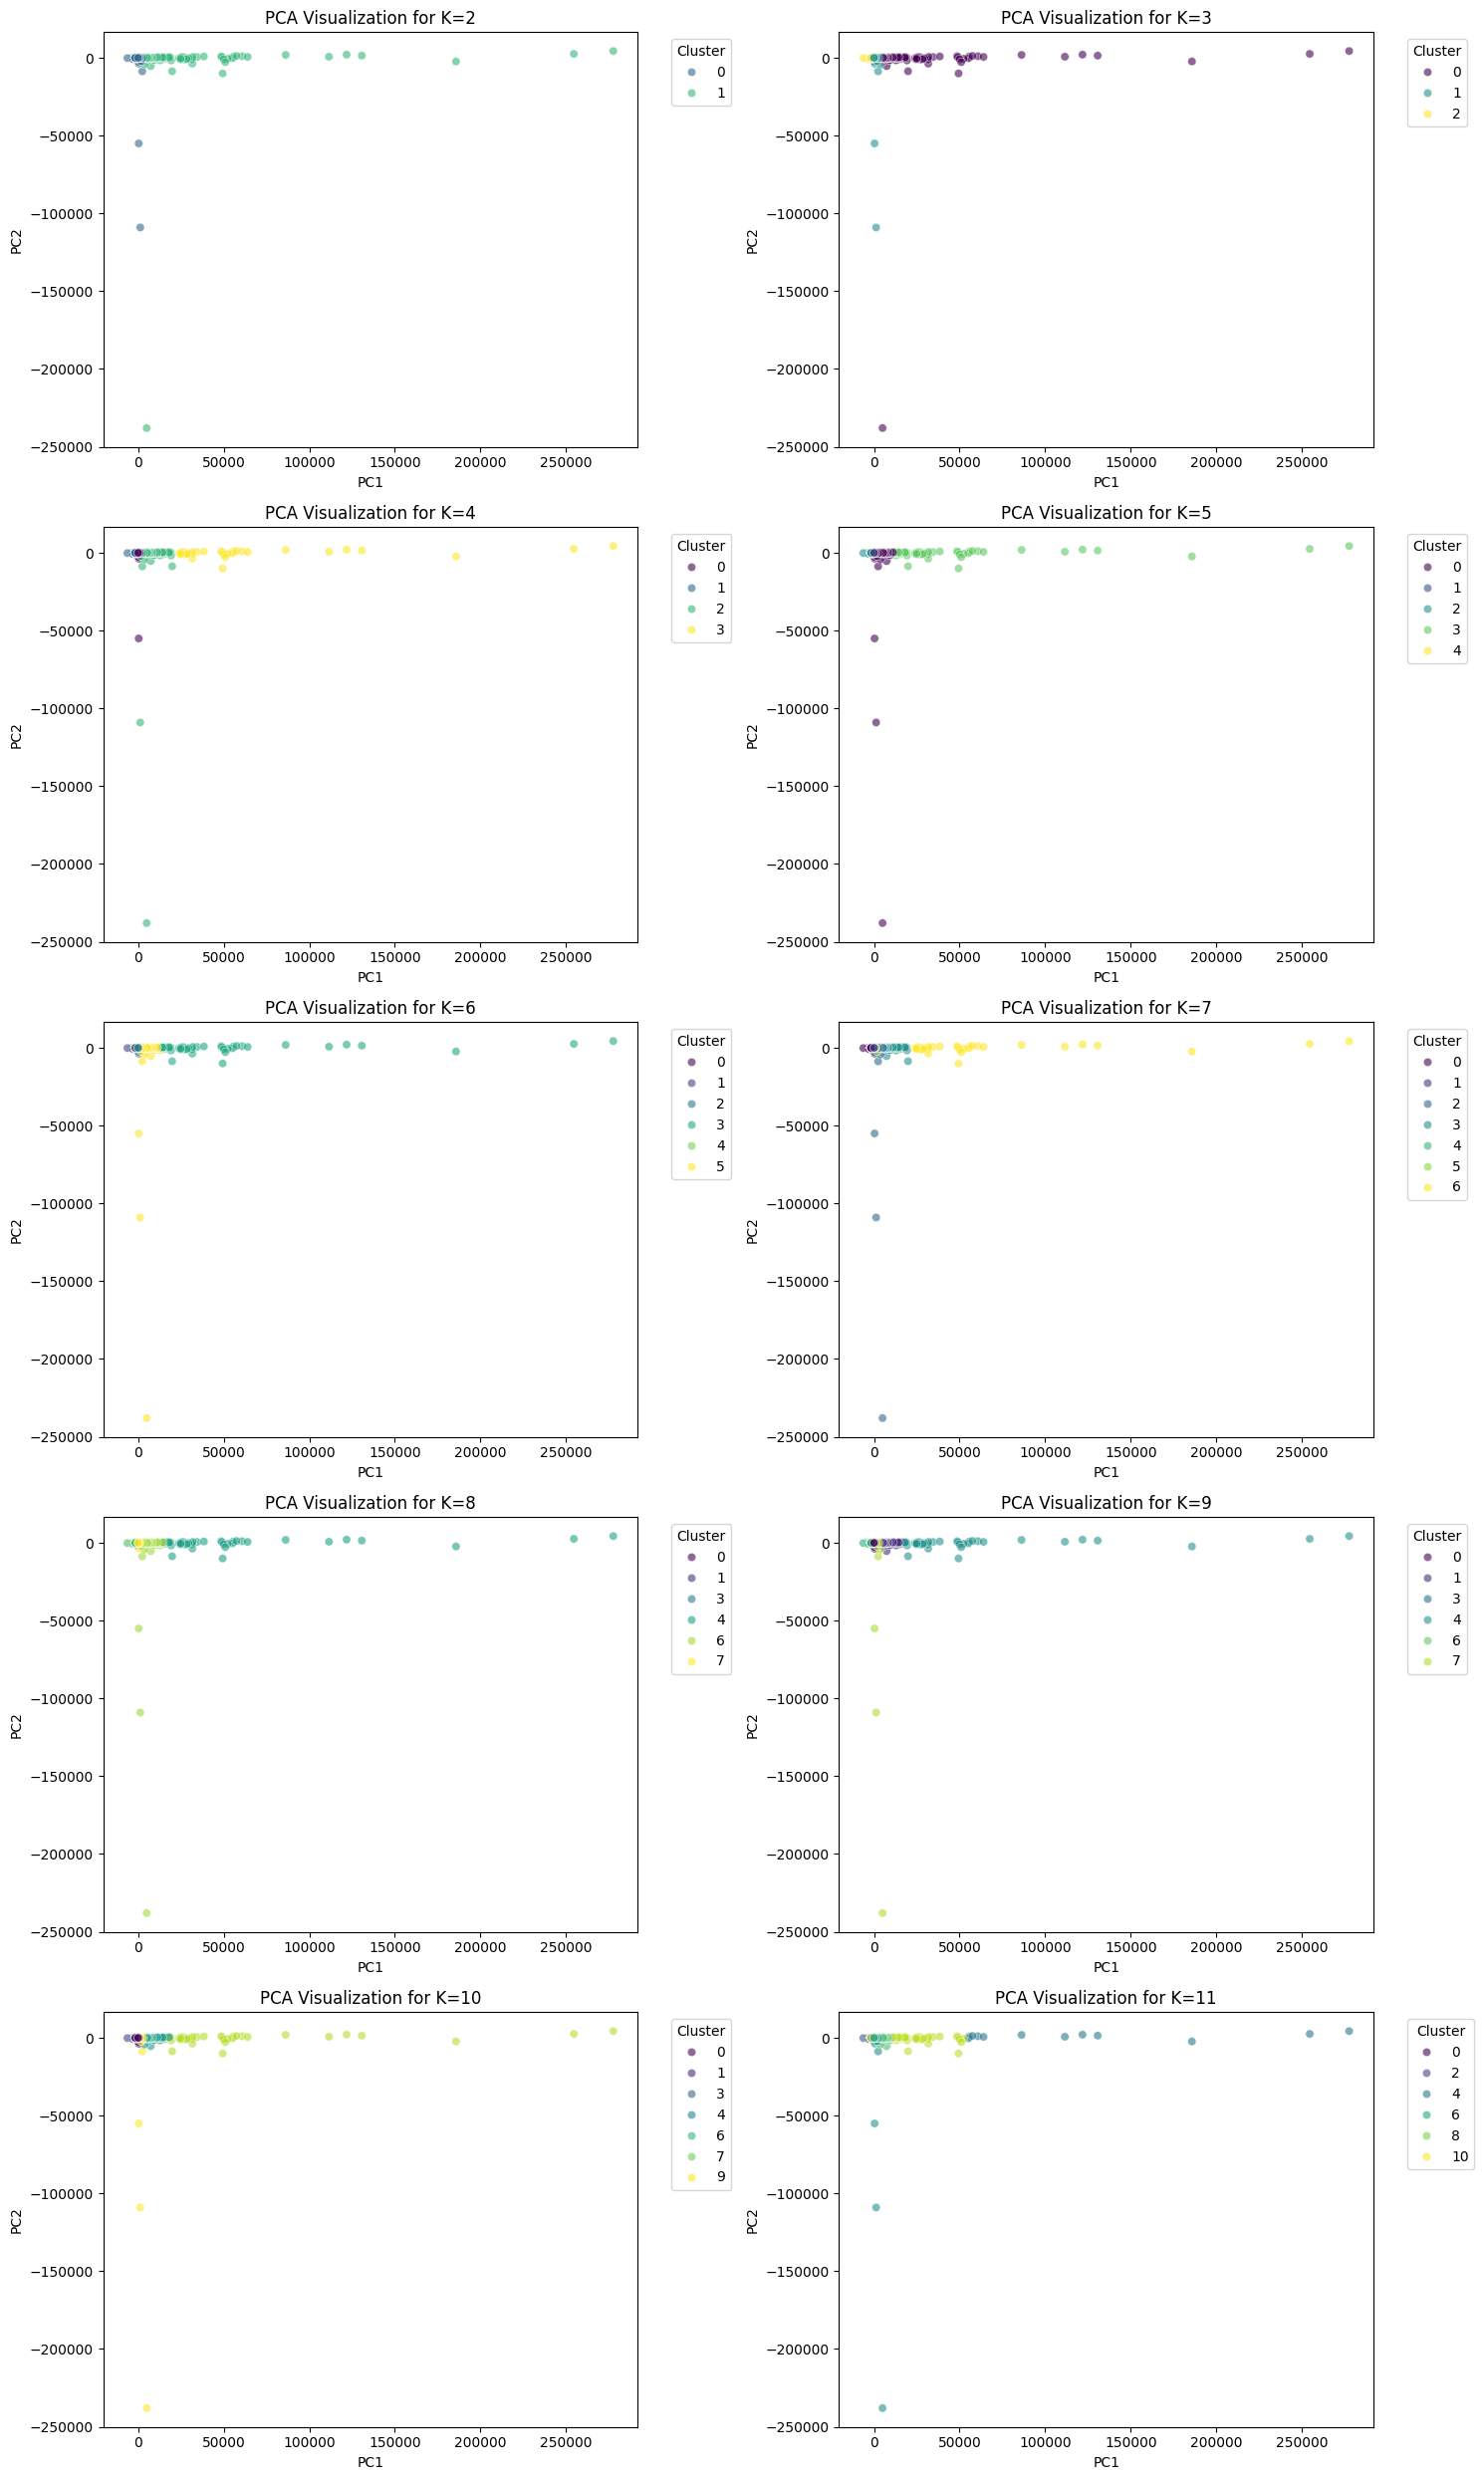

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA

# 读取客户数据
customer_features = pd.read_csv("/content/customer_features.csv")

# 去除 CustomerID（不用于聚类）
X = customer_features.drop(columns=["CustomerID"])

# 设置 K 值范围
K_range = range(2, 12)  # K=2 到 K=11，共 10 个 K 值

# 创建 5 行 2 列的子图（10 个图）
fig, axes = plt.subplots(5, 2, figsize=(15, 25))  # 调整 figsize 以适应长宽比
axes = axes.flatten()  # 将 2D 数组转换为 1D，方便索引

for i, k in enumerate(K_range):
    print(f"正在计算 K={k} ...")

    # 进行聚类
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, n_init=10, batch_size=100)
    labels = kmeans.fit_predict(X)

    # PCA 降维
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # 创建 DataFrame 进行可视化
    df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
    df_pca["Cluster"] = labels

    # **绘制 PCA 聚类散点图**
    sns.scatterplot(ax=axes[i], x="PC1", y="PC2", hue="Cluster", palette="viridis", data=df_pca, alpha=0.6)
    axes[i].set_title(f"PCA Visualization for K={k}")
    axes[i].legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

# 调整子图间距
plt.tight_layout()
plt.show()



##选取k值
最终选择 K=7。






正在计算 K=2 ...
正在计算 K=3 ...
正在计算 K=4 ...
正在计算 K=5 ...
正在计算 K=6 ...
正在计算 K=7 ...
正在计算 K=8 ...
正在计算 K=9 ...
正在计算 K=10 ...
正在计算 K=11 ...


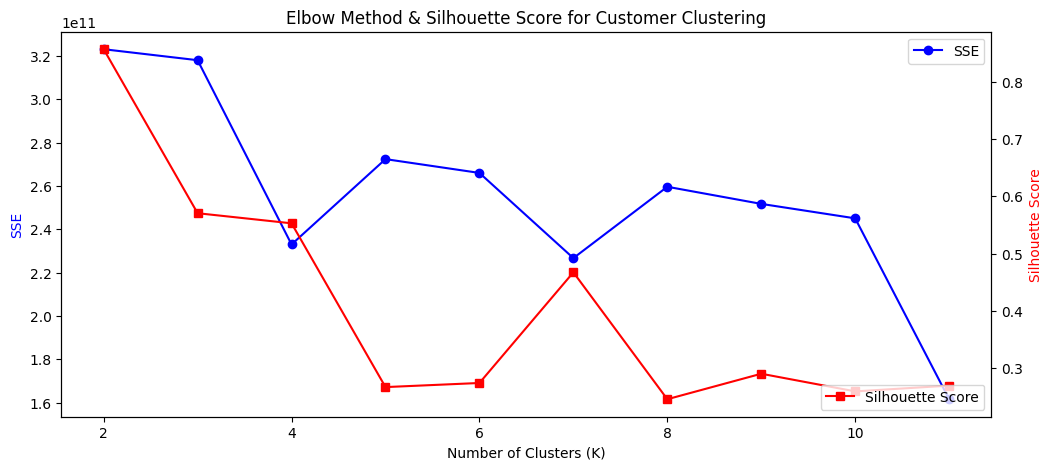

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score



# 存储 SSE 和 Silhouette Score
sse = []
silhouette_scores = []

for k in K_range:
    print(f"正在计算 K={k} ...")

    # MiniBatchKMeans 进行聚类
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, n_init=10, batch_size=100)
    labels = kmeans.fit_predict(X)

    # 计算 SSE 和 Silhouette Score
    sse.append(kmeans.inertia_)
    sample_size = min(5000, X.shape[0])
    silhouette_scores.append(silhouette_score(X[:sample_size], labels[:sample_size]))

# **绘制 Elbow Method & Silhouette Score**
fig, ax1 = plt.subplots(figsize=(12, 5))
ax2 = ax1.twinx()

ax1.plot(K_range, sse, marker='o', linestyle='-', color='b', label='SSE')
ax2.plot(K_range, silhouette_scores, marker='s', linestyle='-', color='r', label='Silhouette Score')

ax1.set_xlabel("Number of Clusters (K)")
ax1.set_ylabel("SSE", color='b')
ax2.set_ylabel("Silhouette Score", color='r')
ax1.set_title("Elbow Method & Silhouette Score for Customer Clustering")

ax1.legend(loc="upper right")
ax2.legend(loc="lower right")

plt.show()


In [ ]:
# **选择最佳 K 进行 MiniBatchKMeans 聚类**
optimal_k = 7  # 你可以根据上图选择最佳 K
print(f"✅ 选择的最佳 K 值: {optimal_k}")

kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, n_init=10, batch_size=100)
customer_features["CustomerCluster"] = kmeans.fit_predict(X)

# **显示客户分类**
print(customer_features[["CustomerID", "CustomerCluster"]].head(10))

# **保存客户聚类结果**
customer_features.to_csv("/content/clustered_customers.csv", index=False)
print("✅ 客户聚类完成，结果已保存到 clustered_customers.csv")


✅ 选择的最佳 K 值: 7
   CustomerID  CustomerCluster
0     12346.0                2
1     12347.0                2
2     12348.0                1
3     12349.0                1
4     12350.0                0
5     12352.0                1
6     12353.0                0
7     12354.0                4
8     12355.0                0
9     12356.0                5
✅ 客户聚类完成，结果已保存到 clustered_customers.csv



##可视化结果




In [ ]:
# 计算每个客户群的统计特征
cluster_summary = customer_features.groupby("CustomerCluster").agg(
    TotalOrders_mean=("TotalOrders", "mean"),
    TotalOrders_median=("TotalOrders", "median"),
    TotalSpent_mean=("TotalSpent", "mean"),
    TotalSpent_median=("TotalSpent", "median"),
    PurchaseFrequency_mean=("PurchaseFrequency", "mean"),
    UniqueProductsBought_mean=("UniqueProductsBought", "mean"),
    DaysSinceLastPurchase_mean=("DaysSinceLastPurchase", "mean")
).reset_index()

# 显示数据
display(cluster_summary)


CustomerCluster  TotalOrders_mean  TotalOrders_median  TotalSpent_mean  \
0                0          1.844406                 1.0       315.357226   
1                1          6.608863                 6.0      1918.688054   
2                2         14.701031                14.0      5398.500722   
3                3         25.305556                22.5     11587.608426   
4                4          4.043771                 4.0      1020.387689   
5                5          9.464497                 9.0      3220.409382   
6                6         63.323529                49.0     67243.962647   

   TotalSpent_median  PurchaseFrequency_mean  UniqueProductsBought_mean  \
0            305.060                0.082823                  25.110140   
1           1880.220                0.890581                  92.944123   
2           5304.900                3.443485                 157.701031   
3          10487.425               10.004450                 183.296296   
4            997.480                0.381247                  60.332211   
5           3156.945                1.772030                 131.653846   
6          50638.965               36.777937                 390.588235   

   DaysSinceLastPurchase_mean  
0                  131.087850  
1                   46.420039  
2                   25.608247  
3                   17.731481  
4                   62.287318  
5                   33.896450  
6                    5.852941

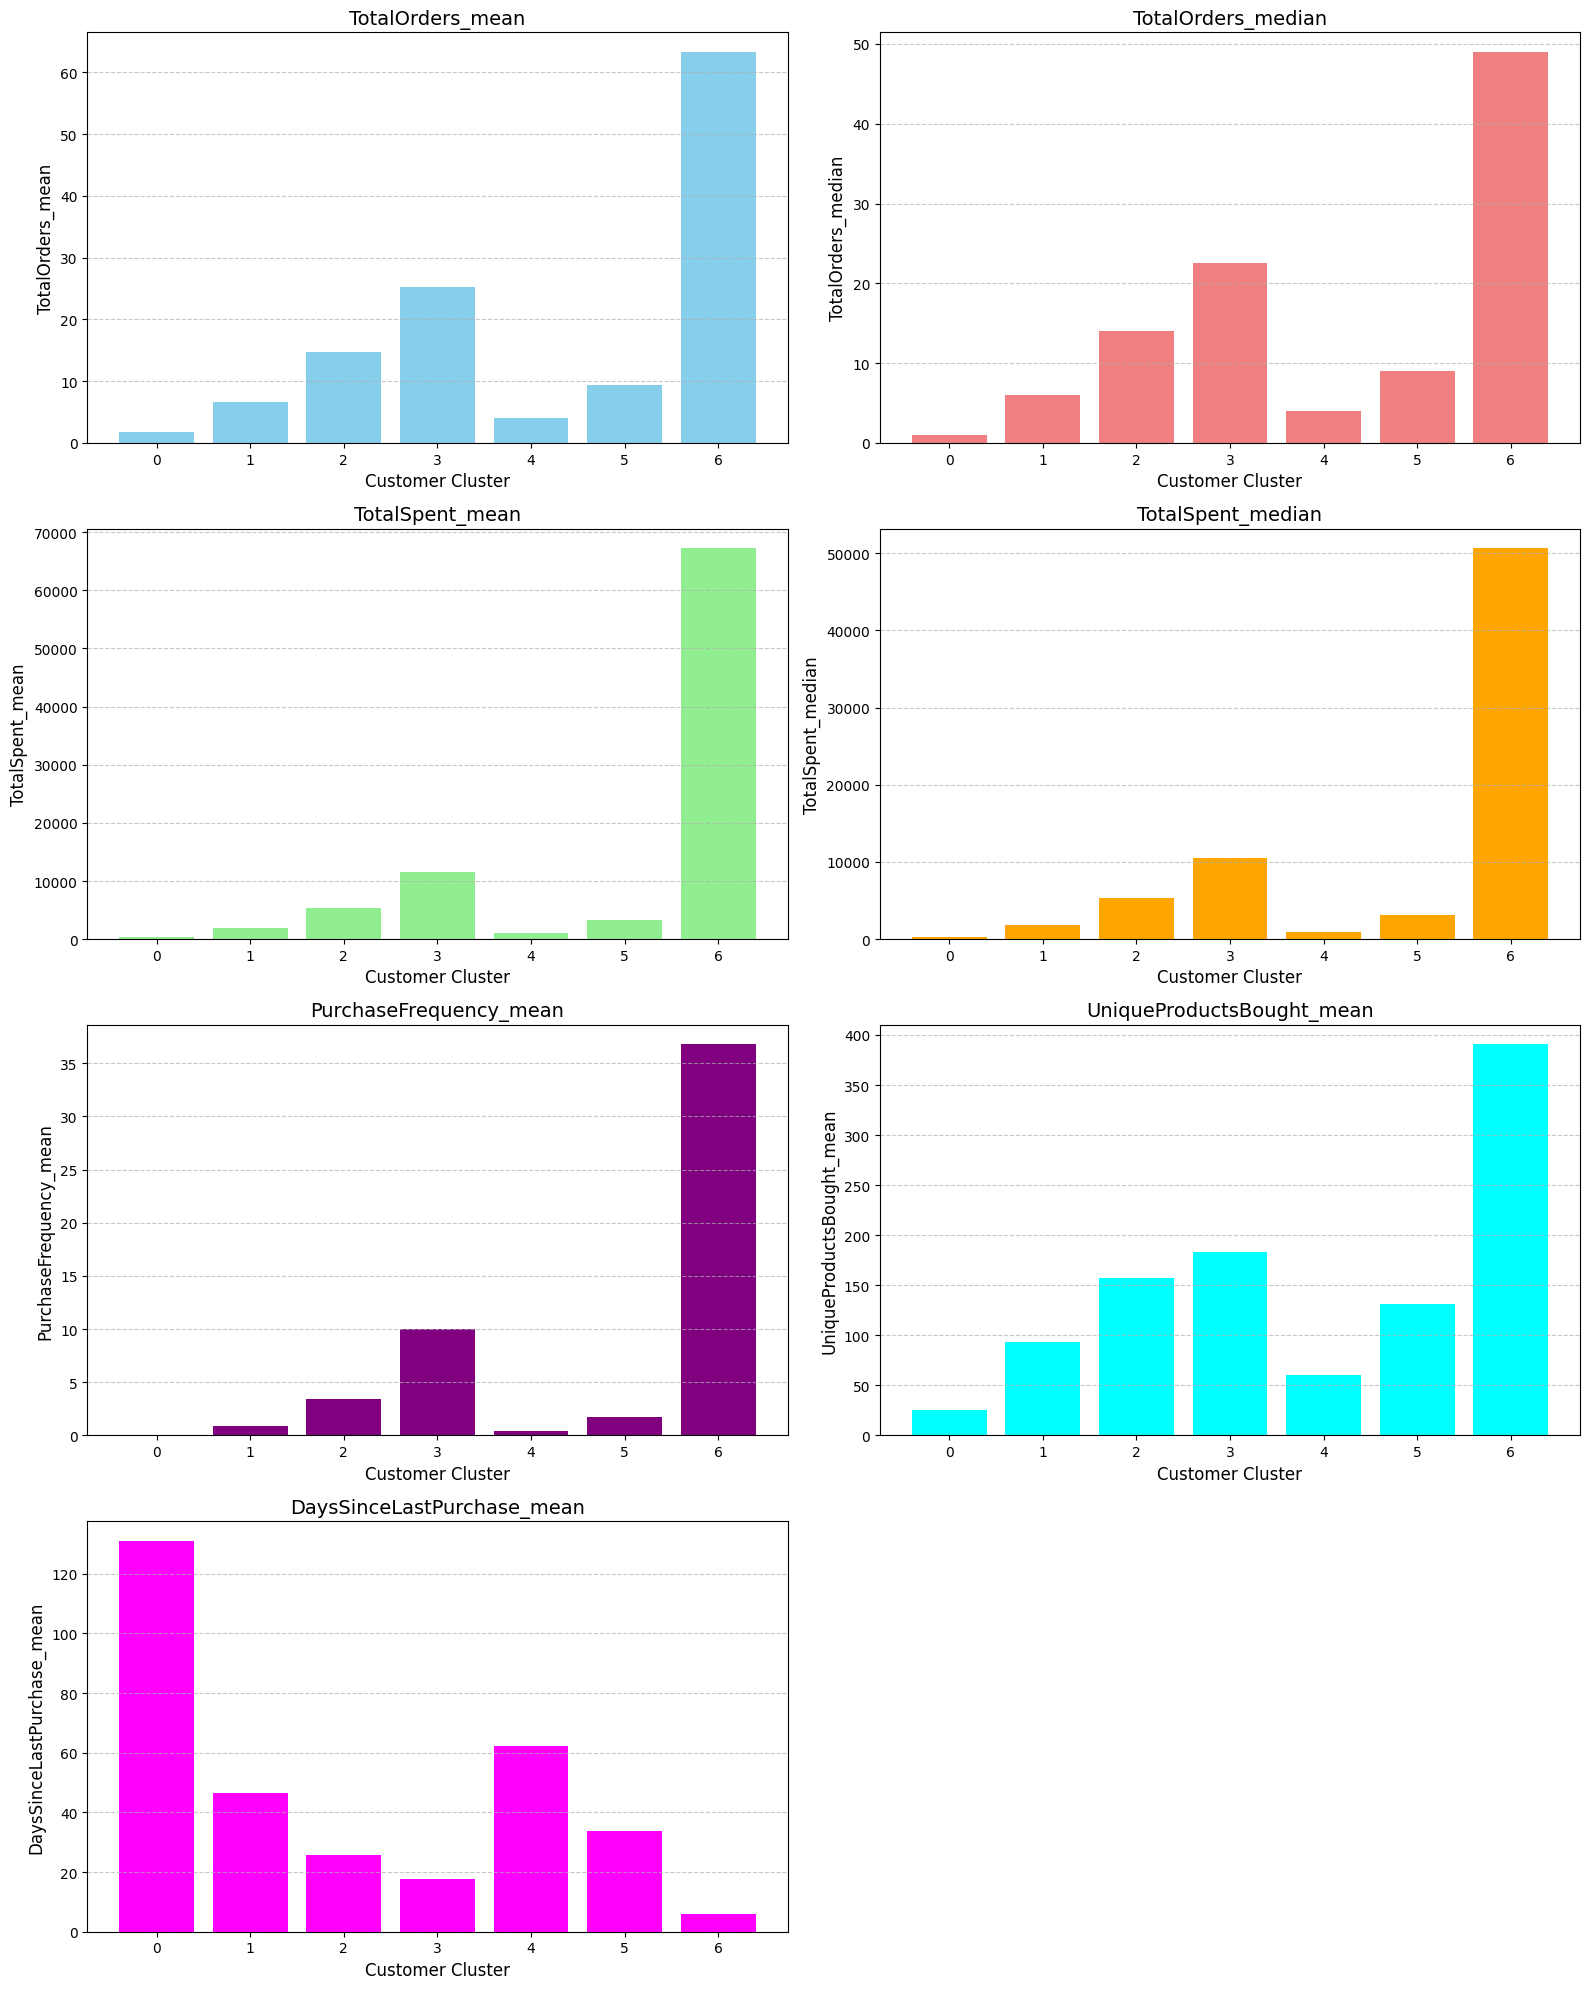

In [ ]:
import matplotlib.pyplot as plt

# 创建 4 行 2 列的子图（最后一个图占两列）
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))
axes = axes.flatten()  # 转为 1D 数组，方便索引

# 要绘制的列
columns = ['TotalOrders_mean', 'TotalOrders_median', 'TotalSpent_mean',
           'TotalSpent_median', 'PurchaseFrequency_mean',
           'UniqueProductsBought_mean', 'DaysSinceLastPurchase_mean']

# 颜色列表
colors = ['skyblue', 'lightcoral', 'lightgreen', 'orange', 'purple', 'cyan', 'magenta']

# 绘制每个柱形图
for i, col in enumerate(columns):
    axes[i].bar(cluster_summary["CustomerCluster"], cluster_summary[col], color=colors[i])
    axes[i].set_title(col, fontsize=14)
    axes[i].set_xlabel("Customer Cluster", fontsize=12)
    axes[i].set_ylabel(col, fontsize=12)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# 隐藏多余的子图
for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])

# 调整布局
plt.tight_layout()
plt.show()


客户群体占比

饼图显示 不同客户群体的占比，Cluster 0 约占 52%，而 Cluster 6 仅占 0.78%，但贡献了最高的销售额。

CustomerCluster  Percentage
0                0   52.333028
1                4   20.379689
2                1   11.870997
3                5    7.731016
4                2    4.437328
5                3    2.470265
6                6    0.777676

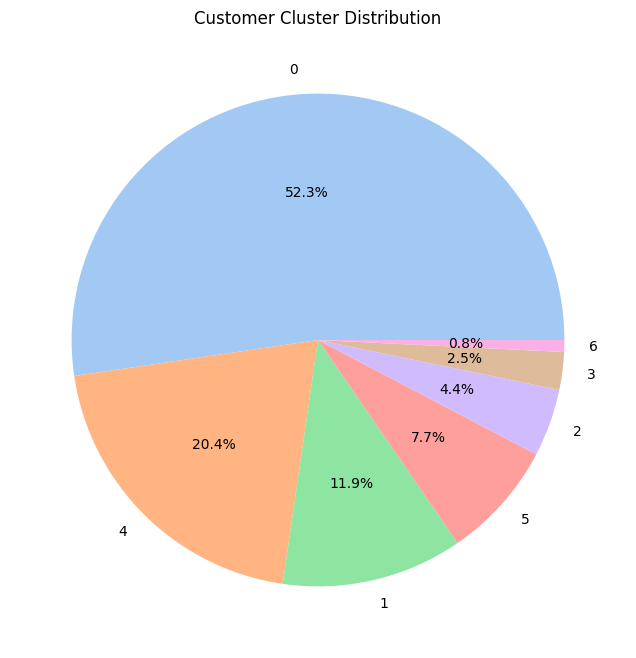

In [ ]:
# 计算每个客户群的客户数量占比
cluster_distribution = customer_features["CustomerCluster"].value_counts(normalize=True) * 100
cluster_distribution = cluster_distribution.reset_index()
cluster_distribution.columns = ["CustomerCluster", "Percentage"]

# 显示数据
display(cluster_distribution)
plt.figure(figsize=(8, 8))
plt.pie(cluster_distribution["Percentage"], labels=cluster_distribution["CustomerCluster"], autopct="%1.1f%%", colors=sns.color_palette("pastel"))
plt.title("Customer Cluster Distribution")
plt.show()



In [ ]:
# 计算各客户群的平均消费金额
high_value_clusters = cluster_summary.sort_values("TotalSpent_mean", ascending=False)

# 显示数据
display(high_value_clusters)



CustomerCluster  TotalOrders_mean  TotalOrders_median  TotalSpent_mean  \
6                6         63.323529                49.0     67243.962647   
3                3         25.305556                22.5     11587.608426   
2                2         14.701031                14.0      5398.500722   
5                5          9.464497                 9.0      3220.409382   
1                1          6.608863                 6.0      1918.688054   
4                4          4.043771                 4.0      1020.387689   
0                0          1.844406                 1.0       315.357226   

   TotalSpent_median  PurchaseFrequency_mean  UniqueProductsBought_mean  \
6          50638.965               36.777937                 390.588235   
3          10487.425               10.004450                 183.296296   
2           5304.900                3.443485                 157.701031   
5           3156.945                1.772030                 131.653846   
1           1880.220                0.890581                  92.944123   
4            997.480                0.381247                  60.332211   
0            305.060                0.082823                  25.110140   

   DaysSinceLastPurchase_mean  
6                    5.852941  
3                   17.731481  
2                   25.608247  
5                   33.896450  
1                   46.420039  
4                   62.287318  
0                  131.087850

 一次性 vs 复购客户分析

柱状图对比 一次性购买客户 与 复购客户 的占比，发现约 30.03% 的客户为一次性购买用户，企业应重点关注 如何提高客户留存率。

一次性购买的客户占比：30.03%


<ipython-input-18-a8723b462871>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["One-time Customers", "Repeat Customers"], y=[one_time_count, multi_time_count], palette="Set2")


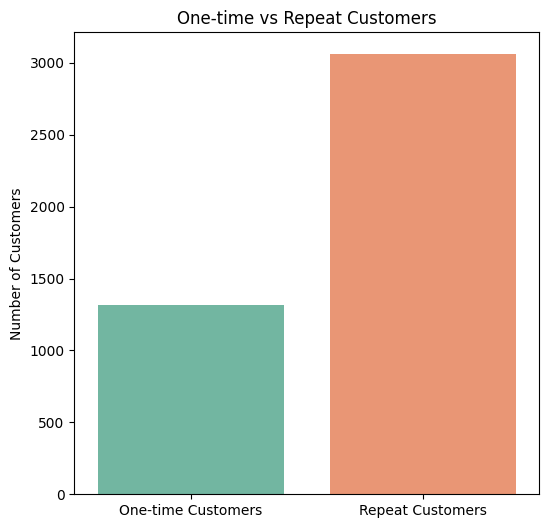

In [ ]:
# 计算一次性购买的客户比例
one_time_customers = customer_features[customer_features["TotalOrders"] == 1]
one_time_percentage = len(one_time_customers) / len(customer_features) * 100

print(f"一次性购买的客户占比：{one_time_percentage:.2f}%")

# 计算一次性客户占比
one_time_count = len(one_time_customers)
multi_time_count = len(customer_features) - one_time_count

plt.figure(figsize=(6, 6))
sns.barplot(x=["One-time Customers", "Repeat Customers"], y=[one_time_count, multi_time_count], palette="Set2")
plt.title("One-time vs Repeat Customers")
plt.ylabel("Number of Customers")
plt.show()



客户群体的平均订单量 vs. 平均总消费

通过柱状图和折线图展示 不同客户群体的平均订单量 和 总消费金额，可以直观地看出 Cluster 6 的订单量和消费金额远超其他客户群。

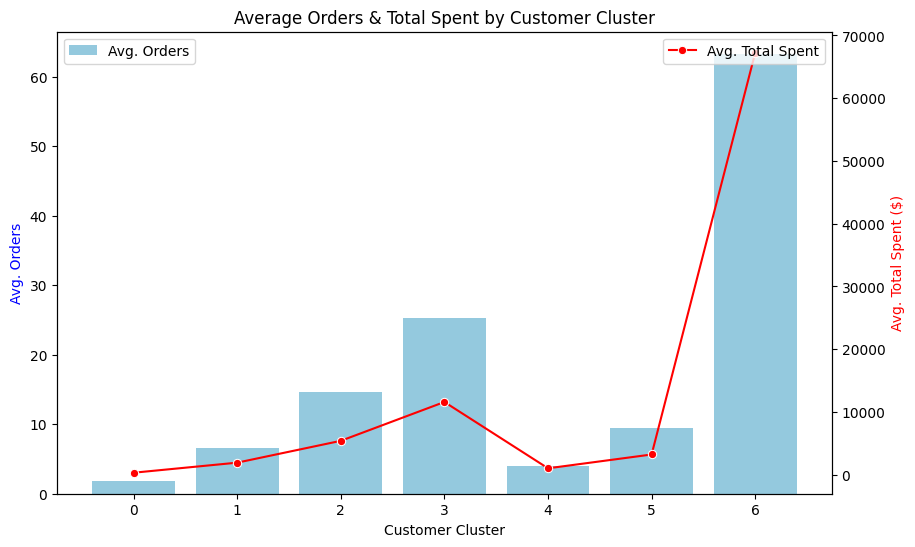

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置画布大小
fig, ax1 = plt.subplots(figsize=(10, 6))

# 绘制不同客户群的平均订单量
sns.barplot(x="CustomerCluster", y="TotalOrders_mean", data=cluster_summary, ax=ax1, color="skyblue", label="Avg. Orders")

# 创建双 Y 轴
ax2 = ax1.twinx()
sns.lineplot(x="CustomerCluster", y="TotalSpent_mean", data=cluster_summary, ax=ax2, color="red", marker="o", label="Avg. Total Spent")

# 设置标题和标签
ax1.set_xlabel("Customer Cluster")
ax1.set_ylabel("Avg. Orders", color="blue")
ax2.set_ylabel("Avg. Total Spent ($)", color="red")
plt.title("Average Orders & Total Spent by Customer Cluster")

# 显示图例
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()


 客户群体的购买频率分布

通过箱线图观察 各个客户群体的购买频率分布，发现 Cluster 6 购买频率最高，而 Cluster 0 和 Cluster 4 购买频率较低。

<ipython-input-20-88fd312d982f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="CustomerCluster", y="PurchaseFrequency", data=customer_features, palette="coolwarm")


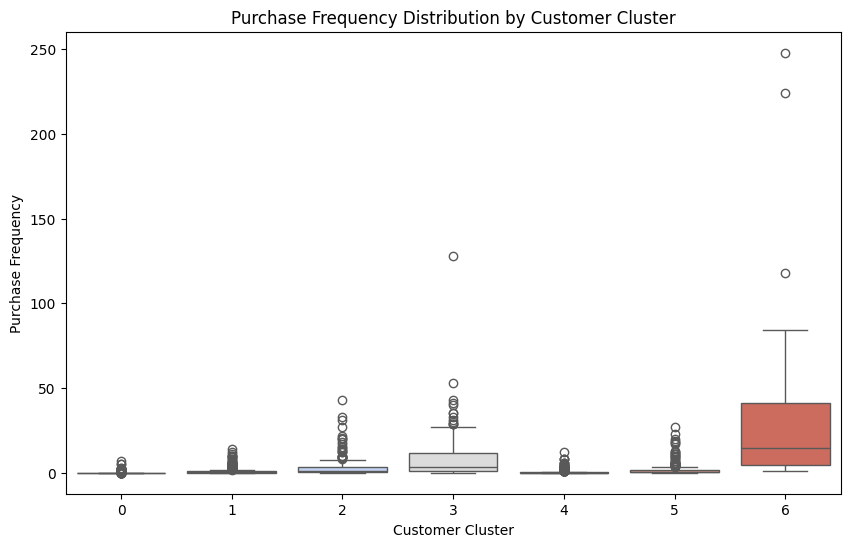

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="CustomerCluster", y="PurchaseFrequency", data=customer_features, palette="coolwarm")
plt.title("Purchase Frequency Distribution by Customer Cluster")
plt.xlabel("Customer Cluster")
plt.ylabel("Purchase Frequency")
plt.show()



##总结

###低价值客户（Cluster 0）
*   订单数（TotalOrders_mean）: 1.84
*   总消费（TotalSpent_mean）: $315
*   购买频率（PurchaseFrequency_mean）: 0.08
*   购买的不同产品数（UniqueProductsBought_mean）: 25
*   距离上次购买天数（DaysSinceLastPurchase_mean）: 131 天
*   客户占比: 52.3%（占比最高）
*   📌 特点:
*   这些客户 购买订单较少，消费金额也很低。
*   购买间隔时间长，很多用户已经 流失。
*   他们可能是 一次性客户，仅仅尝试过一次购买，没有形成复购习惯。
*   📌 策略建议:
*   目标: 提高复购率
*   📌 行动:
*   发送促销邮件，提供 折扣优惠 吸引他们回购。
*   设计忠诚度计划，鼓励二次购买。

###普通客户（Cluster 4）
*   订单数（TotalOrders_mean）: 4.04
*   总消费（TotalSpent_mean）: $1,020
*   购买频率（PurchaseFrequency_mean）: 0.38
*   购买的不同产品数（UniqueProductsBought_mean）: 60
*   距离上次购买天数（DaysSinceLastPurchase_mean）: 62 天
*   客户占比: 20.4%
*   📌 特点:
*   他们购买频率 低于高价值客户，但仍然 有一定的活跃度。
*   购买金额较低，但有复购意愿。
*   📌 策略建议:
*   目标: 提升消费金额
*   📌 行动:
*   提供 个性化推荐，推送他们之前浏览过的商品。
*   发送限时折扣 提升客单价。

###复购客户（Cluster 1）
*   订单数（TotalOrders_mean）: 6.6
*   总消费（TotalSpent_mean）: $1,918
*   购买频率（PurchaseFrequency_mean）: 0.89
*   购买的不同产品数（UniqueProductsBought_mean）: 92
*   距离上次购买天数（DaysSinceLastPurchase_mean）: 46 天
*   客户占比: 11.87%
*   📌 特点:
*   购买频率高，但消费金额仍然偏低。
*   对品牌有一定忠诚度，但 客单价不高。
*   📌 策略建议:
*   目标: 提高单次消费金额
*   📌 行动:
*   进行 捆绑销售，增加单笔订单金额。
*   提供 VIP 会员折扣，鼓励大额消费。



###高价值客户（Cluster 5）
*   订单数（TotalOrders_mean）: 9.46
*   总消费（TotalSpent_mean）: $3,220
*   购买频率（PurchaseFrequency_mean）: 1.77
*   购买的不同产品数（UniqueProductsBought_mean）: 131
*   距离上次购买天数（DaysSinceLastPurchase_mean）: 33 天
*   客户占比: 7.73%
*   📌 特点:
*   消费金额高，订单数多，是高价值客户。
*   购买品类多样化，说明他们对品牌有较高的信任度。
*   📌 策略建议:
*   目标: 培养品牌忠诚度
*   📌 行动:
*   设立 VIP 会员制度，为他们提供专属福利。
*   发送 定制化推荐，基于他们的购买习惯推荐新品。



###超高价值客户（Cluster 2）

*   订单数（TotalOrders_mean）: 14.7
*   总消费（TotalSpent_mean）: $5,398
*   购买频率（PurchaseFrequency_mean）: 3.44
*   购买的不同产品数（UniqueProductsBought_mean）: 157
*   距离上次购买天数（DaysSinceLastPurchase_mean）: 25 天
*   客户占比: 4.43%
*   📌 特点:
*   消费金额和购买频率都非常高。
*   对品牌忠诚度极高，可能是 核心用户。
*   📌 策略建议:
*   目标: 培养超级忠诚用户
*   行动:
*   提供专属折扣，例如积分兑换系统。
*   给予他们优先购买权，例如限量版商品。

###超级 VIP 客户（Cluster 3）

*   订单数（TotalOrders_mean）: 25.3
*   总消费（TotalSpent_mean）: $11,587
*   购买频率（PurchaseFrequency_mean）: 10.00
*   购买的不同产品数（UniqueProductsBought_mean）: 183
*   距离上次购买天数（DaysSinceLastPurchase_mean）: 17 天
*   客户占比: 2.47%
*   📌 特点:
*   极高的购买频率和消费金额，是品牌最重要的客户。
*   购买种类最多，可能是企业客户或重度消费者。
*   📌 策略建议:
*   目标: 维护长期关系
*   📌 行动:
*   提供 个性化服务，如 私人购物顾问。
*   建立长期合作，提供 订阅制服务（如 VIP 会员月度特供）。


###终极 VIP 客户（Cluster 6）

*   订单数（TotalOrders_mean）: 63.3
*   总消费（TotalSpent_mean）: $67,243
*   购买频率（PurchaseFrequency_mean）: 36.77
*   购买的不同产品数（UniqueProductsBought_mean）: 390
*   距离上次购买天数（DaysSinceLastPurchase_mean）: 5.85 天
*   客户占比: 0.77%
*   📌 特点:
*   这个群体是品牌的最大贡献者，极其忠诚。
*   他们的购买频率极高，消费金额极高。
*   可能是批发商、企业用户或超级富豪消费者。
*   📌 策略建议:
*   目标: 维护终极 VIP
*   📌 行动:
*   提供白金会员服务，如私人订制 和优先配送。
*   邀请到品牌活动，增加粘性，例如VIP见面会。



*   Cluster 6 贡献了最高的销售额，但占比很少，应该提供VIP服务。

*   Cluster 0 是一次性客户，需要重点关注复购策略。

*   Cluster 3、Cluster 5 是高价值客户，应该通过会员体系锁定他们。





# 设计分类器

上一步基于客户的购买行为进行了 K-Means 客户聚类分析，在这一部分将进一步使用机器学习分类器对客户类别进行预测。


##目标
*   训练分类器，以便未来可以预测新客户所属的客户类别
*   评估不同机器学习模型的性能，以选择最佳模型


###数据处理
*   数据来源: clustered_customers.csv，包含 客户的消费行为、订单次数、消费频率、购买的不同产品类别占比等信息。






In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import learning_curve

# 读取数据
file_path = "/content/clustered_customers.csv"
customer_features = pd.read_csv(file_path)

# **检查特征是否和 CustomerCluster 直接相关**
correlation_matrix = customer_features.corr()
print("\n**相关性矩阵（与 CustomerCluster 相关的特征）**")
print(correlation_matrix["CustomerCluster"].sort_values(ascending=False))





**相关性矩阵（与 CustomerCluster 相关的特征）**
CustomerCluster          1.000000
UniqueProductsBought     0.387591
TotalOrders              0.342378
TotalSpent               0.246776
PurchaseFrequency        0.171448
AvgOrderValue            0.076652
Category_2               0.068655
MaxOrderValue            0.030987
Category_4               0.029225
Category_0               0.002822
Category_3               0.000991
MinOrderValue           -0.014412
Category_1              -0.018181
Category_5              -0.047674
CustomerID              -0.072844
DaysSinceLastPurchase   -0.343077
Name: CustomerCluster, dtype: float64



*   数据清洗: 去除了 CustomerID 等无关字段，并对数据进行了标准化处理，以确保所有特征都处于相同的尺度。
*   目标变量: CustomerCluster，即客户所属的类别（Cluster 0 - Cluster 6）。


##机器学习模型选择
*   为了找到最佳的分类器，我们首先对 多个分类模型 进行了 测试集准确率 和 交叉验证准确率 的评估。
尝试的模型包括：
*   逻辑回归（Logistic Regression）
*   K 近邻（KNN）
*   决策树（Decision Tree）
*   随机森林（Random Forest）
*   梯度提升（Gradient Boosting）
*   投票分类器（Voting Classifier）




Logistic Regression 测试集准确率: 0.6663
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       458
           1       0.41      0.37      0.39       104
           2       0.44      0.18      0.25        39
           3       0.37      0.33      0.35        21
           4       0.48      0.50      0.49       178
           5       0.47      0.37      0.41        68
           6       1.00      0.14      0.25         7

    accuracy                           0.67       875
   macro avg       0.57      0.40      0.43       875
weighted avg       0.65      0.67      0.65       875



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28102 (\N{CJK UNIFIED IDEOGRAPH-6DC6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30697 (\N{CJK UNIFIED IDEOGRAPH-77E9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38453 (\N{CJK UNIFIED IDEOGRAPH-9635}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


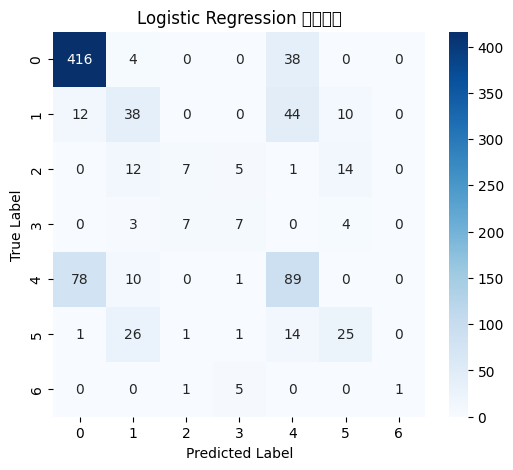


KNN 测试集准确率: 0.7211
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       458
           1       0.46      0.53      0.49       104
           2       0.43      0.38      0.41        39
           3       0.44      0.33      0.38        21
           4       0.60      0.59      0.59       178
           5       0.47      0.34      0.39        68
           6       1.00      0.43      0.60         7

    accuracy                           0.72       875
   macro avg       0.61      0.50      0.54       875
weighted avg       0.71      0.72      0.72       875



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28102 (\N{CJK UNIFIED IDEOGRAPH-6DC6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30697 (\N{CJK UNIFIED IDEOGRAPH-77E9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38453 (\N{CJK UNIFIED IDEOGRAPH-9635}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


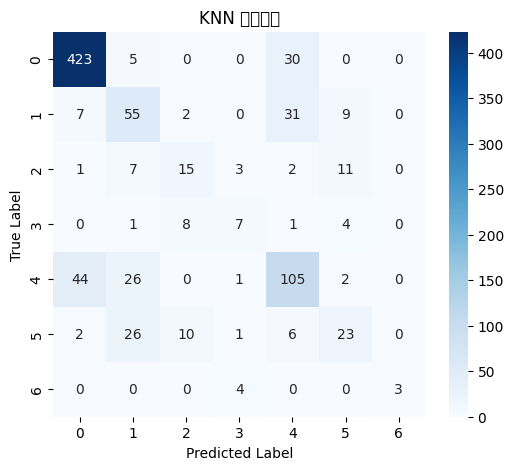


Decision Tree 测试集准确率: 0.7829
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       458
           1       0.56      0.56      0.56       104
           2       0.45      0.51      0.48        39
           3       0.65      0.52      0.58        21
           4       0.72      0.72      0.72       178
           5       0.48      0.44      0.46        68
           6       0.83      0.71      0.77         7

    accuracy                           0.78       875
   macro avg       0.66      0.63      0.64       875
weighted avg       0.78      0.78      0.78       875



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28102 (\N{CJK UNIFIED IDEOGRAPH-6DC6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30697 (\N{CJK UNIFIED IDEOGRAPH-77E9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38453 (\N{CJK UNIFIED IDEOGRAPH-9635}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


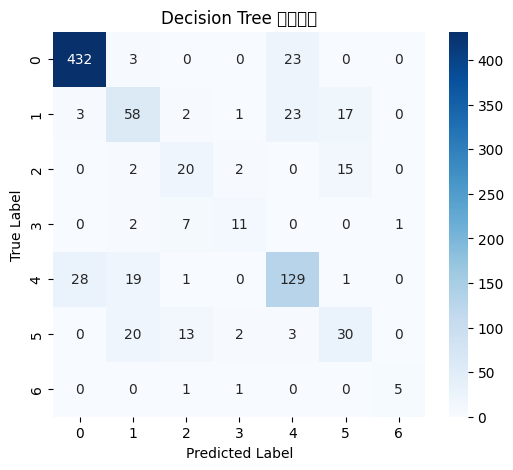


Random Forest 测试集准确率: 0.8229
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       458
           1       0.62      0.58      0.60       104
           2       0.52      0.41      0.46        39
           3       0.62      0.38      0.47        21
           4       0.76      0.81      0.79       178
           5       0.57      0.56      0.56        68
           6       0.88      1.00      0.93         7

    accuracy                           0.82       875
   macro avg       0.70      0.67      0.68       875
weighted avg       0.82      0.82      0.82       875



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28102 (\N{CJK UNIFIED IDEOGRAPH-6DC6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30697 (\N{CJK UNIFIED IDEOGRAPH-77E9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38453 (\N{CJK UNIFIED IDEOGRAPH-9635}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


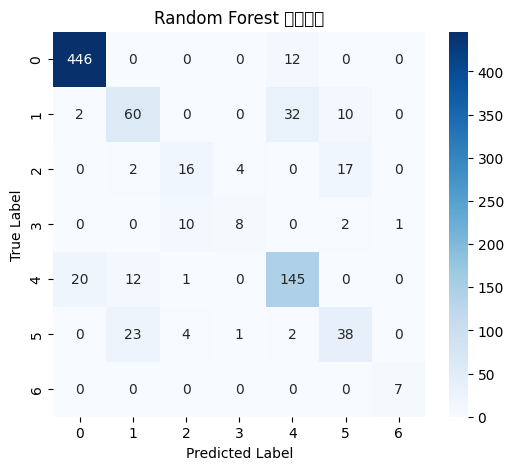


AdaBoost 测试集准确率: 0.6537
              precision    recall  f1-score   support

           0       0.81      0.91      0.85       458
           1       0.43      0.44      0.44       104
           2       0.42      0.38      0.40        39
           3       0.30      0.14      0.19        21
           4       0.45      0.41      0.43       178
           5       0.44      0.29      0.35        68
           6       0.00      0.00      0.00         7

    accuracy                           0.65       875
   macro avg       0.41      0.37      0.38       875
weighted avg       0.63      0.65      0.64       875



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/IPython/c

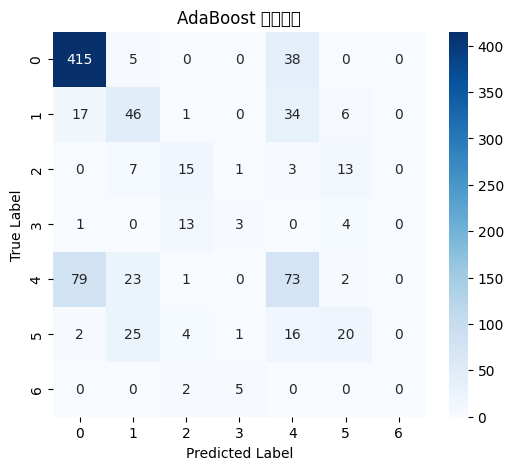


Gradient Boosting 测试集准确率: 0.8389
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       458
           1       0.66      0.63      0.65       104
           2       0.52      0.38      0.44        39
           3       0.73      0.52      0.61        21
           4       0.78      0.85      0.81       178
           5       0.60      0.60      0.60        68
           6       0.86      0.86      0.86         7

    accuracy                           0.84       875
   macro avg       0.73      0.69      0.71       875
weighted avg       0.83      0.84      0.84       875



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28102 (\N{CJK UNIFIED IDEOGRAPH-6DC6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30697 (\N{CJK UNIFIED IDEOGRAPH-77E9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38453 (\N{CJK UNIFIED IDEOGRAPH-9635}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


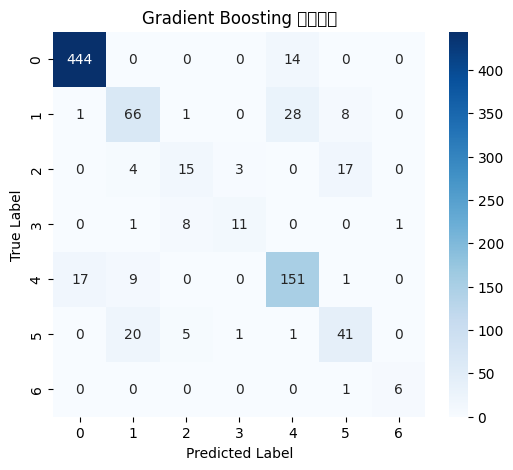

In [ ]:

# **去除高度相关特征**
X = customer_features.drop(columns=["CustomerID", "CustomerCluster",
                                    "Category_0", "Category_1", "Category_2",
                                    "Category_3", "Category_4", "Category_5",
                                    "TotalSpent", "PurchaseFrequency"])  # **移除可疑特征**
y = customer_features["CustomerCluster"]

# **数据标准化**
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# **划分训练集 & 测试集**
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# **定义分类器**
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(max_depth=25, min_samples_split=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=25, min_samples_split=5),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, learning_rate=0.5),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)
}

# **存储模型交叉验证准确率**
results = []

# **训练模型，进行交叉验证**
for name, model in classifiers.items():
    # 交叉验证
    cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring="accuracy")
    avg_accuracy = np.mean(cv_scores)
    results.append({"Model": name, "Cross-Validation Accuracy": avg_accuracy})

    # 训练模型
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # **输出分类报告**
    print(f"\n{name} 测试集准确率: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))

    # **绘制混淆矩阵**
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} 混淆矩阵")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()





##结果分析
*   对比了各个模型的 测试集准确率 和 交叉验证准确率，结果如下：
*   模型     交叉验证准确率     测试集准确率
*   逻辑回归 0.6603 0.6663
*   KNN 0.7116 0.7211
*   决策树 0.7925 0.7829
*   随机森林 0.8248 0.8229
*   AdaBoost 0.6446 0.6537
*   梯度提升 0.8381 0.8389










<ipython-input-23-87754ff7cfc1>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Cross-Validation Accuracy", data=accuracy_df, palette="viridis")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30830 (\N{CJK UNIFIED IDEOGRAPH-786E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151:

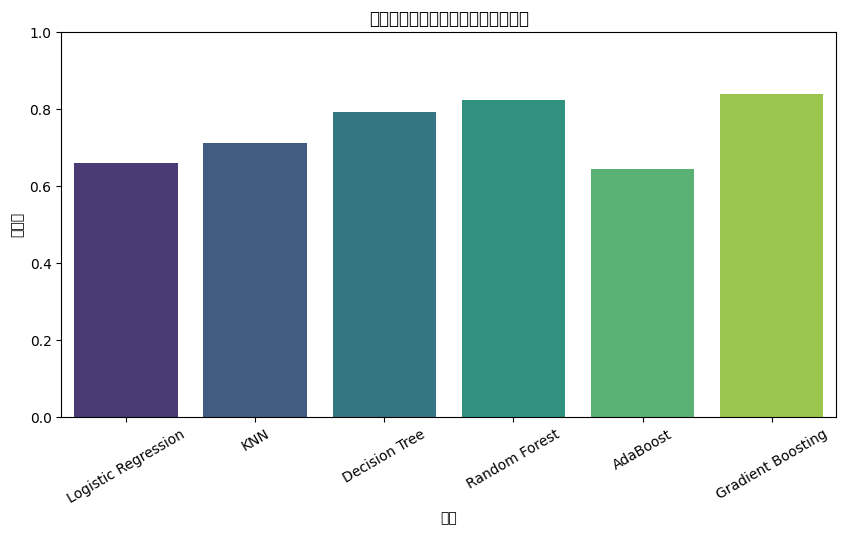


模型交叉验证准确性对比:
                  Model  Cross-Validation Accuracy
0  Logistic Regression                   0.660343
1                  KNN                   0.711572
2        Decision Tree                   0.792542
3        Random Forest                   0.824793
4             AdaBoost                   0.644560
5    Gradient Boosting                   0.838061


In [ ]:

# **转换为 DataFrame 并展示结果**
accuracy_df = pd.DataFrame(results)

# **绘制准确率对比图**
plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="Cross-Validation Accuracy", data=accuracy_df, palette="viridis")
plt.title("不同分类模型的交叉验证准确率对比")
plt.xlabel("模型")
plt.ylabel("准确率")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.show()

# **输出最终准确率表格**
print("\n模型交叉验证准确性对比:\n", accuracy_df)





##投票分类器优化

###组合模型
*   基于初步的测试发现：
*   随机森林、梯度提升的性能最好
*   KNN 和逻辑回归虽然单独表现一般，但与其他模型结合时可以提供额外的决策信息
*   AdaBoost 和决策树效果较差，未被纳入最终投票分类器

###权重调整
*   通过多次测试，发现以下权重组合效果最佳：
*   随机森林（权重 2）
*   梯度提升（权重 3）
*   KNN（权重 1）
*   逻辑回归（权重 0.5）
*   最终模型准确率：0.8446












##模型性能评估

###混淆矩阵分析
*   Cluster 0（大额高频客户） 识别效果最好，Precision 和 Recall 都很高。
*   Cluster 2 和 Cluster 3（中等客户） 识别效果较差，部分客户被误分类为 Cluster 1 或 Cluster 5。
*   Cluster 6（稀有客户） 由于样本较少，在部分模型中 Recall 较低。


###学习曲线分析
*   投票分类器学习曲线较平稳，泛化能力强。


投票分类器测试集准确率: 0.8446
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       458
           1       0.67      0.65      0.66       104
           2       0.56      0.46      0.51        39
           3       0.71      0.57      0.63        21
           4       0.79      0.84      0.81       178
           5       0.65      0.59      0.62        68
           6       1.00      0.86      0.92         7

    accuracy                           0.84       875
   macro avg       0.76      0.71      0.73       875
weighted avg       0.84      0.84      0.84       875



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28102 (\N{CJK UNIFIED IDEOGRAPH-6DC6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30697 (\N{CJK UNIFIED IDEOGRAPH-77E9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38453 (\N{CJK UNIFIED IDEOGRAPH-9635}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


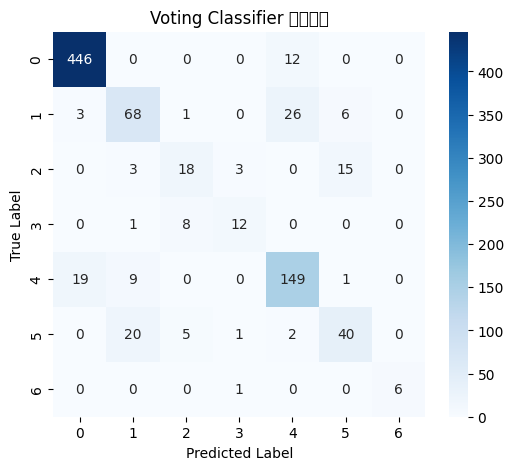

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23398 (\N{CJK UNIFIED IDEOGRAPH-5B66}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20064 (\N{CJK UNIFIED IDEOGRAPH-4E60}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


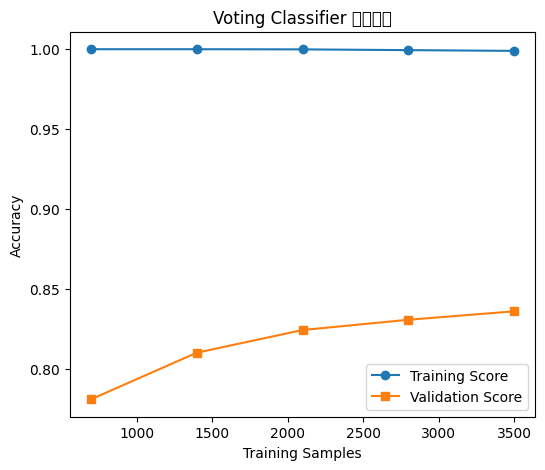

In [ ]:

# **创建投票分类器（Voting Classifier）**
voting_clf = VotingClassifier(estimators=[
    ("Random Forest", classifiers["Random Forest"]),
    ("Gradient Boosting", classifiers["Gradient Boosting"]),
    ("KNN", classifiers["KNN"]),
    ("Logistic Regression", classifiers["Logistic Regression"])
], voting="soft", weights=[2, 3, 1, 0.5])

# **训练投票分类器**
voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)

# **计算投票分类器准确率**
print(f"\n投票分类器测试集准确率: {accuracy_score(y_test, y_pred_voting):.4f}")
print(classification_report(y_test, y_pred_voting))

# **绘制投票分类器混淆矩阵**
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_voting), annot=True, fmt="d", cmap="Blues")
plt.title("Voting Classifier 混淆矩阵")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# **绘制学习曲线**
def plot_learning_curve(model, X, y, model_name):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring="accuracy", train_sizes=np.linspace(0.2, 1.0, 5))

    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(6, 5))
    plt.plot(train_sizes, train_mean, label="Training Score", marker="o")
    plt.plot(train_sizes, test_mean, label="Validation Score", marker="s")
    plt.title(f"{model_name} 学习曲线")
    plt.xlabel("Training Samples")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

# **绘制投票分类器的学习曲线**
plot_learning_curve(voting_clf, X_scaled, y, "Voting Classifier")


投票分类器测试集准确率: 0.8411
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       458
           1       0.67      0.64      0.66       104
           2       0.55      0.44      0.49        39
           3       0.76      0.62      0.68        21
           4       0.77      0.84      0.81       178
           5       0.63      0.54      0.58        68
           6       1.00      1.00      1.00         7

    accuracy                           0.84       875
   macro avg       0.76      0.72      0.74       875
weighted avg       0.84      0.84      0.84       875



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28102 (\N{CJK UNIFIED IDEOGRAPH-6DC6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30697 (\N{CJK UNIFIED IDEOGRAPH-77E9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38453 (\N{CJK UNIFIED IDEOGRAPH-9635}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


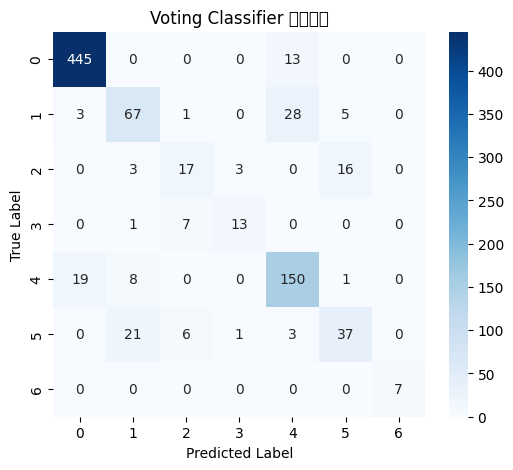

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23398 (\N{CJK UNIFIED IDEOGRAPH-5B66}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20064 (\N{CJK UNIFIED IDEOGRAPH-4E60}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


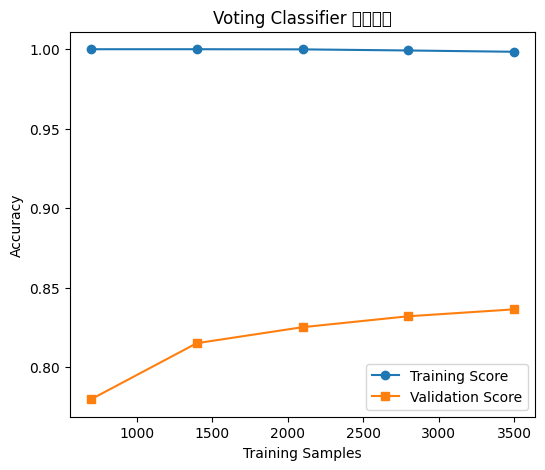

In [ ]:

# **创建投票分类器（Voting Classifier）**
voting_clf = VotingClassifier(estimators=[
    ("Random Forest", classifiers["Random Forest"]),
    ("Gradient Boosting", classifiers["Gradient Boosting"]),
    ("KNN", classifiers["KNN"]),
    ("Logistic Regression", classifiers["Logistic Regression"])
], voting="soft", weights=[3, 3, 1, 1])

# **训练投票分类器**
voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)

# **计算投票分类器准确率**
print(f"\n投票分类器测试集准确率: {accuracy_score(y_test, y_pred_voting):.4f}")
print(classification_report(y_test, y_pred_voting))

# **绘制投票分类器混淆矩阵**
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_voting), annot=True, fmt="d", cmap="Blues")
plt.title("Voting Classifier 混淆矩阵")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# **绘制学习曲线**
def plot_learning_curve(model, X, y, model_name):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring="accuracy", train_sizes=np.linspace(0.2, 1.0, 5))

    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(6, 5))
    plt.plot(train_sizes, train_mean, label="Training Score", marker="o")
    plt.plot(train_sizes, test_mean, label="Validation Score", marker="s")
    plt.title(f"{model_name} 学习曲线")
    plt.xlabel("Training Samples")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

# **绘制投票分类器的学习曲线**
plot_learning_curve(voting_clf, X_scaled, y, "Voting Classifier")


投票分类器测试集准确率: 0.8377
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       458
           1       0.68      0.62      0.65       104
           2       0.55      0.46      0.50        39
           3       0.71      0.57      0.63        21
           4       0.77      0.82      0.79       178
           5       0.65      0.60      0.63        68
           6       1.00      0.86      0.92         7

    accuracy                           0.84       875
   macro avg       0.76      0.70      0.73       875
weighted avg       0.83      0.84      0.83       875



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28102 (\N{CJK UNIFIED IDEOGRAPH-6DC6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30697 (\N{CJK UNIFIED IDEOGRAPH-77E9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38453 (\N{CJK UNIFIED IDEOGRAPH-9635}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


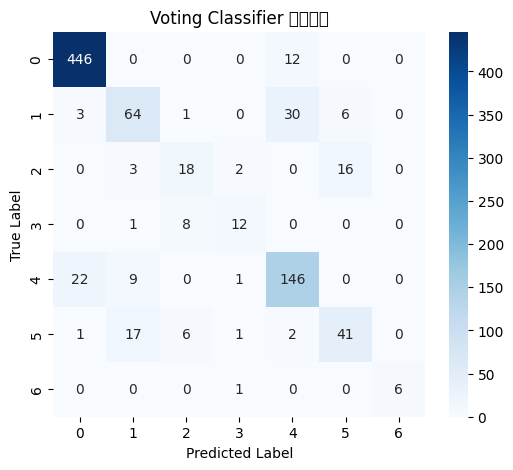

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23398 (\N{CJK UNIFIED IDEOGRAPH-5B66}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20064 (\N{CJK UNIFIED IDEOGRAPH-4E60}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


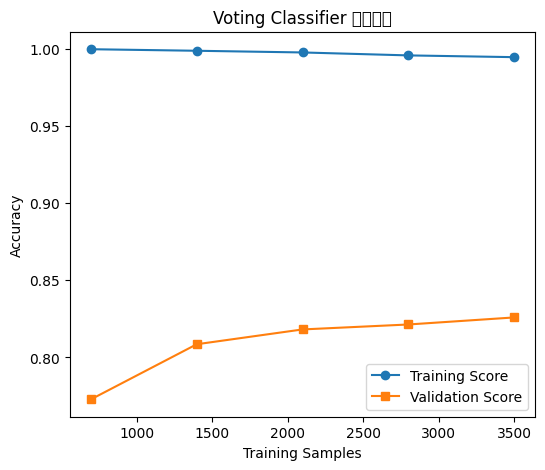

In [ ]:

# **创建投票分类器（Voting Classifier）**
voting_clf = VotingClassifier(estimators=[
    ("Random Forest", classifiers["Random Forest"]),
    ("Gradient Boosting", classifiers["Gradient Boosting"]),
    ("KNN", classifiers["KNN"]),
    ("Logistic Regression", classifiers["Logistic Regression"])
], voting="soft", weights=[2, 2, 2, 1])

# **训练投票分类器**
voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)

# **计算投票分类器准确率**
print(f"\n投票分类器测试集准确率: {accuracy_score(y_test, y_pred_voting):.4f}")
print(classification_report(y_test, y_pred_voting))

# **绘制投票分类器混淆矩阵**
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_voting), annot=True, fmt="d", cmap="Blues")
plt.title("Voting Classifier 混淆矩阵")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# **绘制学习曲线**
def plot_learning_curve(model, X, y, model_name):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring="accuracy", train_sizes=np.linspace(0.2, 1.0, 5))

    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(6, 5))
    plt.plot(train_sizes, train_mean, label="Training Score", marker="o")
    plt.plot(train_sizes, test_mean, label="Validation Score", marker="s")
    plt.title(f"{model_name} 学习曲线")
    plt.xlabel("Training Samples")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

# **绘制投票分类器的学习曲线**
plot_learning_curve(voting_clf, X_scaled, y, "Voting Classifier")



##结论
*   投票分类器 (Voting Classifier) 是最佳选择，具有最高的预测准确率（84.46%）。
*   梯度提升 (Gradient Boosting) 作为单一模型的最佳选择，泛化能力强，适合实际业务场景。







##后续优化方向
*   特征优化：尝试更多特征工程，如加入时间维度特征、客户行为模式分析。
*   模型优化：测试更多的集成学习方法，如 Stacking、XGBoost、CatBoost 等。
*   业务应用：结合 动态 RFM 分层，优化客户营销策略。


# Acknowledgements
Per the UCI Machine Learning Repository, this data was made available by Dr Daqing Chen, Director: Public Analytics group. chend '@' lsbu.ac.uk, School of Engineering, London South Bank University, London SE1 0AA, UK.